#**Medical Image Analysis with AI**
###**Radiomics Project**

* Juan Sebastian Peña Valderrama



>**Objective:**
*The primary objective of this project is to build and structure a robust dataset of radiomic features derived from medical images in order to address a supervised classification problem. Through the extraction of quantitative descriptors—such as intensity, texture, shape, and spatial relationships—from medical scans, this project seeks to transform qualitative imaging data into high-dimensional, mineable information that can be used to develop machine learning models capable of identifying and classifying pathological patterns.*

Standardize the processing pipeline for medical images (e.g., DICOM or NRRD formats) using reproducible preprocessing and feature extraction steps based on PyRadiomics.

Extract and organize radiomic features (first-order statistics, texture matrices such as GLCM, GLRLM, GLSZM, NGTDM, GLDM, and shape descriptors) to create a structured, well-labeled dataset suitable for downstream analysis.

Integrate metadata and clinical labels to enable the training of machine learning or deep learning classifiers for diagnostic support.

Evaluate the discriminative power of radiomic biomarkers, exploring their potential utility for non-invasive diagnosis, prognosis, or treatment response assessment.

Ensure methodological rigor and reproducibility through proper feature standardization, feature selection strategies, and robust model evaluation metrics.


#### **Import Libraries**


In [ ]:
!pip install pydicom pynrrd pyradiomics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from IPython.display import display, clear_output
import ipywidgets as widgets
from scipy import signal

from skimage.filters import threshold_otsu
from skimage.measure import label
from collections import Counter, OrderedDict

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### **Import Dataset**

In [ ]:
!git clone https://github.com/pocheche50/porfin.git

Cloning into 'porfin'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 172 (delta 2), reused 1 (delta 1), pack-reused 168
Receiving objects: 100% (172/172), 19.07 MiB | 37.69 MiB/s, done.
Resolving deltas: 100% (4/4), done.


#### **Radiomics masks function**



In [ ]:
def funcion_allmighty(path):
    # Read the image using Matplotlib
    img = plt.imread(path)

    # Select only the green channel of the image
    img = img[:,:,1]

    # Normalize the image
    a = np.min(img)
    b = np.max(img)
    img = img - a
    b = np.max(img)
    img = img / b
    img = 255 * img
    y = img.astype(np.uint8)

    # Apply Otsu thresholding to obtain a binary image
    thresh = threshold_otsu(y)
    binary = y > thresh

    # Label the connected regions in the binary image
    labels, num = label(binary, return_num=True)

    # Find the largest region (the one with the most pixels)
    q = np.bincount(labels.flat)
    island = labels == np.argmax(q[1:]) + 1

    # Create a Radiomics feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()

    # Prints the enabled extraction parameters
    print('Extraction parameters:\n\t', extractor.settings)
    print('Enabled filters:\n\t', extractor.enabledImagetypes)
    print('Enabled features:\n\t', extractor.enabledFeatures)

    # Save the original image and mask as nrrd files
    sitk.WriteImage(sitk.GetImageFromArray(np.fliplr(np.rot90(y.astype(int), 3))), 'original.nrrd')
    sitk.WriteImage(sitk.GetImageFromArray(np.fliplr(np.rot90(island.astype(int), 3))), 'mask.nrrd')

    path = '/content/original.nrrd'
    pathmask = '/content/mask.nrrd'

    # Extract features using Radiomics
    results = extractor.execute(path, pathmask)

    # Create lists to store feature keys and values
    claves = []
    valores = []

    # Iterates over the results and stores keys and values ​​in lists
    for clave, valor in results.items():
        claves.append(clave)
        valores.append(valor)

    # Create a feature matrix
    matriz = []

    for i in range(len(claves)):
        actual = [claves[i], valores[i]]
        matriz.append(actual)

    # Create a DataFrame from the feature matrix
    dataframe = pd.DataFrame(matriz)
    df = dataframe.T

    # Gets the file name from the path
    filename = os.path.basename(path)

    # Write the DataFrame to a CSV file
    csv_filename = 'results.csv'

    if not os.path.exists(csv_filename):
        df.to_csv(csv_filename, index=False, header=False)
    else:
        df.to_csv(csv_filename, mode='a', index=False, header=False)

    # Returns the labels, the island, and the DataFrame
    return labels, island, df

#### **Image type**

In [ ]:
def obtener_tipo(nombre):
  if 'Malignant case ' in nombre:
      return 'M'

  elif 'Bengin case ' in nombre:
      return 'B'

  else:
      return 'N'

#### **CSV with all images and type information**

In [ ]:
ruta_carpeta_principal = '/content/porfin'
resultados_totales = []

# Create a list to store the types
tipos = ['type']

# Browse the main folder
for carpeta in os.listdir(ruta_carpeta_principal):
    ruta_carpeta = os.path.join(ruta_carpeta_principal, carpeta)

    # Check if it is a folder
    if os.path.isdir(ruta_carpeta):
        print("Procesando carpeta:", carpeta)

        # Browse through the images in the folder
        for imagen in os.listdir(ruta_carpeta):
            if imagen.endswith('.jpg'):

                # Call the function to process the image and get the results
                ruta_imagen = os.path.join(ruta_carpeta, imagen)
                labels, island, df = funcion_allmighty(ruta_imagen)

                # Add the results to the list
                resultados_totales.append(df)

                tipo_imagen = obtener_tipo(imagen)
                # Add the type to the list
                tipos.append(tipo_imagen)


# Concatenate the DataFrames of all images
resultados_completos = pd.concat(resultados_totales, ignore_index=True)

#### **Final CSV**

In [ ]:
# Read the CSV file with the title row
resultados_completos = pd.read_csv('/content/data_all_csv.csv')

# Extract the title row (zero row)
titulos = resultados_completos.iloc[0]

# Delete rows that are identical to the title row, except row zero
resultados_filtrados = resultados_completos[resultados_completos.ne(titulos).any(axis=1)]

# Insert the title row at the beginning of the DataFrame
resultados_filtrados = pd.concat([titulos.to_frame().T, resultados_filtrados])

# Add the 'type' column to the DataFrame
resultados_filtrados.insert(0, 'tipo', tipos[:len(resultados_filtrados)])

# Save the results to a CSV file
resultados_filtrados.to_csv('resultado_final.csv', index=False)

#### **Cell separation process**

In [ ]:
def separar(dataframe):
    # Copy the original column names
    nombres_originales = dataframe.iloc[0].copy()  # Copy of the original names

    # Iterate over the columns of the DataFrame
    for columna in dataframe.columns:

        # Check if any cell in the column contains a comma
        if dataframe[columna].apply(lambda x: ',' in str(x)).any():

            # Split cells containing commas into new columns
            nuevas_columnas = dataframe[columna].str.split(',', expand=True)

            # Assign names to new columns with suffix
            nuevas_columnas.columns = [f"{columna}_{i+1}" for i in range(nuevas_columnas.shape[1])]

            # Concatenate the new columns to the DataFrame
            dataframe = pd.concat([dataframe.drop(columns=[columna]), nuevas_columnas], axis=1)

    # Add suffixes to column names in row zero
    for columna in dataframe.columns:

        # Check if the column has a suffix name
        if dataframe.columns.get_loc(columna) > len(nombres_originales) - 1:
            # Get the suffix of the original column name
            sufijo = nombres_originales[columna.split('_')[0]]  # Original column name

            # Add the suffix to the zero row
            dataframe.loc[0, columna] = f"{sufijo} {columna.split('_')[-1]}"

    return dataframe

# Get the new dataframe with the columns separated
data = pd.read_csv("/content/data_all_csv.csv")
nuevo_data = separar(data.copy())

# Display the first rows of the new data frame
nuevo_data.head()

# Save the results to a CSV file
nuevo_data.to_csv('final2.csv', index=False)

### Correlation Analysis


In [ ]:
def separar_y_modificar(dataframe):
    # Step 1: Split columns that contain comma-separated values
    def separar_columnas(dataframe):
        columnas_a_eliminar = []
        nuevas_columnas = pd.DataFrame()

        for columna in dataframe.columns:
            # Check if the column has any cell with a comma
            if dataframe[columna].apply(lambda x: ',' in str(x)).any():
                columnas_a_eliminar.append(columna)
                # Split the column and concatenate the new ones
                nuevas_columnas = pd.concat([nuevas_columnas, dataframe[columna].str.split(',', expand=True)], axis=1)

        # Remove original columns and add new ones
        dataframe = dataframe.drop(columns=columnas_a_eliminar)
        dataframe = pd.concat([dataframe, nuevas_columnas], axis=1)
        return dataframe

    # Step 2: Fill empty cells in the first row with the previous value
    def llenar_celdas_vacias(dataframe):
        celdas_vacias = dataframe.iloc[0].isna()
        for col in dataframe.columns:
            # If the first row cell is empty, copy the previous column value
            if celdas_vacias[col]:
                dataframe.loc[0, col] = dataframe.loc[0, col - 1]
        return dataframe

    # Step 3: Add suffixes to repeated column names in the header
    def asignar_sufijos(dataframe):
        conteo_repeticiones = {}
        for col in dataframe.columns:
            nombre = dataframe.loc[0, col]
            # If the name was seen before, increment and add suffix
            if nombre in conteo_repeticiones:
                conteo_repeticiones[nombre] += 1
                dataframe.loc[0, col] = f"{nombre}_{conteo_repeticiones[nombre]}"
            else:
                conteo_repeticiones[nombre] = 0
        return dataframe

    # Run the three steps in order
    dataframe = separar_columnas(dataframe.copy())
    dataframe.columns = range(len(dataframe.columns))  # Reset column indexes
    dataframe = llenar_celdas_vacias(dataframe)
    dataframe = asignar_sufijos(dataframe)

    # Get the column names of the first row
    nuevos_nombres = dataframe.iloc[0]

    # Assign the new column names
    dataframe.columns = nuevos_nombres

    # Delete the first row from the DataFrame
    dataframe = dataframe.drop(dataframe.index[0])

    # Reset DataFrame Indexes
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

In [ ]:
data = pd.read_csv("/content/resultado_final.csv")
nuevo_data = separar_y_modificar(data.copy())
nuevo_data.head()

# Go through all columns and remove parentheses
for columna in nuevo_data.columns:
    nuevo_data[columna] = nuevo_data[columna].str.replace(r'\(|\)', '', regex=True)

# Save the updated CSV file
nuevo_data.to_csv('finales.csv', index=False)
nuevo_data.head()

0 type diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0    B                           v3.0.1                     1.25.2   
1    B                           v3.0.1                     1.25.2   
2    B                           v3.0.1                     1.25.2   
3    B                           v3.0.1                     1.25.2   
4    B                           v3.0.1                     1.25.2   

0 diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.3.1                          1.6.0   
1                          2.3.1                          1.6.0   
2                          2.3.1                          1.6.0   
3                          2.3.1                          1.6.0   
4                          2.3.1                          1.6.0   

0 diagnostics_Versions_Python diagnostics_Configuration_EnabledImageTypes  \
0                     3.10.12                            {'Original': {}}   
1                     3.10.12                            {'Original': {}}   
2                     3.10.12                            {'Original': {}}   
3                     3.10.12                            {'Original': {}}   
4                     3.10.12                            {'Original': {}}   

0           diagnostics_Image-original_Hash  \
0  2a56e892943018578e3056a961f970e62956a278   
1  a2263da60d0429de28b1bbb574952011dee172e2   
2  d67d74876bdd1ca6e778268e96f26fb4e1bbf783   
3  71703c1371f0bfbad0c357abb1ce315904e838bf   
4  1ffaf38ad949bae8c25dce10a0e4f38fbde8cd9d   

0 diagnostics_Image-original_Dimensionality diagnostics_Image-original_Mean  \
0                                        2D               82.43013000488281   
1                                        2D               86.11873626708984   
2                                        2D               69.64891815185547   
3                                        2D               83.18022155761719   
4                                        2D               58.98882293701172   

0  ... diagnostics_Mask-original_Size diagnostics_Mask-original_Size_1  \
0  ...                            512                              512   
1  ...                            512                              512   
2  ...                            512                              512   
3  ...                            512                              512   
4  ...                            512                              512   

0 diagnostics_Mask-original_BoundingBox  \
0                                    23   
1                                    32   
2                                    70   
3                                    30   
4                                    43   

0 diagnostics_Mask-original_BoundingBox_1  \
0                                      76   
1                                      79   
2                                      91   
3                                      42   
4                                     115   

0 diagnostics_Mask-original_BoundingBox_2  \
0                                     472   
1                                     448   
2                                     403   
3                                     445   
4                                     417   

0 diagnostics_Mask-original_BoundingBox_3  \
0                                     308   
1                                     339   
2                                     282   
3                                     343   
4                                     277   

0 diagnostics_Mask-original_CenterOfMassIndex  \
0                          252.66206367924528   
1                          264.72727169930795   
2                          267.77480212831813   
3                          252.61837491457828   
4                          253.08694800569802   

0 diagnostics_Mask-original_CenterOfMassIndex_1  \
0                            240.11545990566037   
1                              257.384854

In [ ]:
def asignar_etiqueta(valor):
    if valor == 'M':
        return '0'
    elif valor == 'B':
        return '1'
    else:
        return '2'

# Apply the function to the "type" column of the DataFrame
nuevo_data['type'] = nuevo_data['type'].map(asignar_etiqueta)
nuevo_data.head()

0 type diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0    1                           v3.0.1                     1.25.2   
1    1                           v3.0.1                     1.25.2   
2    1                           v3.0.1                     1.25.2   
3    1                           v3.0.1                     1.25.2   
4    1                           v3.0.1                     1.25.2   

0 diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.3.1                          1.6.0   
1                          2.3.1                          1.6.0   
2                          2.3.1                          1.6.0   
3                          2.3.1                          1.6.0   
4                          2.3.1                          1.6.0   

0 diagnostics_Versions_Python diagnostics_Configuration_EnabledImageTypes  \
0                     3.10.12                            {'Original': {}}   
1                     3.10.12                            {'Original': {}}   
2                     3.10.12                            {'Original': {}}   
3                     3.10.12                            {'Original': {}}   
4                     3.10.12                            {'Original': {}}   

0           diagnostics_Image-original_Hash  \
0  2a56e892943018578e3056a961f970e62956a278   
1  a2263da60d0429de28b1bbb574952011dee172e2   
2  d67d74876bdd1ca6e778268e96f26fb4e1bbf783   
3  71703c1371f0bfbad0c357abb1ce315904e838bf   
4  1ffaf38ad949bae8c25dce10a0e4f38fbde8cd9d   

0 diagnostics_Image-original_Dimensionality diagnostics_Image-original_Mean  \
0                                        2D               82.43013000488281   
1                                        2D               86.11873626708984   
2                                        2D               69.64891815185547   
3                                        2D               83.18022155761719   
4                                        2D               58.98882293701172   

0  ... diagnostics_Mask-original_Size diagnostics_Mask-original_Size_1  \
0  ...                            512                              512   
1  ...                            512                              512   
2  ...                            512                              512   
3  ...                            512                              512   
4  ...                            512                              512   

0 diagnostics_Mask-original_BoundingBox  \
0                                    23   
1                                    32   
2                                    70   
3                                    30   
4                                    43   

0 diagnostics_Mask-original_BoundingBox_1  \
0                                      76   
1                                      79   
2                                      91   
3                                      42   
4                                     115   

0 diagnostics_Mask-original_BoundingBox_2  \
0                                     472   
1                                     448   
2                                     403   
3                                     445   
4                                     417   

0 diagnostics_Mask-original_BoundingBox_3  \
0                                     308   
1                                     339   
2                                     282   
3                                     343   
4                                     277   

0 diagnostics_Mask-original_CenterOfMassIndex  \
0                          252.66206367924528   
1                          264.72727169930795   
2                          267.77480212831813   
3                          252.61837491457828   
4                          253.08694800569802   

0 diagnostics_Mask-original_CenterOfMassIndex_1  \
0                            240.11545990566037   
1                              257.384854

In [ ]:
nuevo_data.isnull().sum()

0
type                                             0
diagnostics_Versions_PyRadiomics                 0
diagnostics_Versions_Numpy                       0
diagnostics_Versions_SimpleITK                   0
diagnostics_Versions_PyWavelet                   0
                                                ..
diagnostics_Mask-original_BoundingBox_3          0
diagnostics_Mask-original_CenterOfMassIndex      0
diagnostics_Mask-original_CenterOfMassIndex_1    0
diagnostics_Mask-original_CenterOfMass           0
diagnostics_Mask-original_CenterOfMass_1         0
Length: 139, dtype: int64

In [ ]:
nuevo_data.head()

0 type diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0    1                           v3.0.1                     1.25.2   
1    1                           v3.0.1                     1.25.2   
2    1                           v3.0.1                     1.25.2   
3    1                           v3.0.1                     1.25.2   
4    1                           v3.0.1                     1.25.2   

0 diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.3.1                          1.6.0   
1                          2.3.1                          1.6.0   
2                          2.3.1                          1.6.0   
3                          2.3.1                          1.6.0   
4                          2.3.1                          1.6.0   

0 diagnostics_Versions_Python diagnostics_Configuration_EnabledImageTypes  \
0                     3.10.12                            {'Original': {}}   
1                     3.10.12                            {'Original': {}}   
2                     3.10.12                            {'Original': {}}   
3                     3.10.12                            {'Original': {}}   
4                     3.10.12                            {'Original': {}}   

0           diagnostics_Image-original_Hash  \
0  2a56e892943018578e3056a961f970e62956a278   
1  a2263da60d0429de28b1bbb574952011dee172e2   
2  d67d74876bdd1ca6e778268e96f26fb4e1bbf783   
3  71703c1371f0bfbad0c357abb1ce315904e838bf   
4  1ffaf38ad949bae8c25dce10a0e4f38fbde8cd9d   

0 diagnostics_Image-original_Dimensionality diagnostics_Image-original_Mean  \
0                                        2D               82.43013000488281   
1                                        2D               86.11873626708984   
2                                        2D               69.64891815185547   
3                                        2D               83.18022155761719   
4                                        2D               58.98882293701172   

0  ... diagnostics_Mask-original_Size diagnostics_Mask-original_Size_1  \
0  ...                            512                              512   
1  ...                            512                              512   
2  ...                            512                              512   
3  ...                            512                              512   
4  ...                            512                              512   

0 diagnostics_Mask-original_BoundingBox  \
0                                    23   
1                                    32   
2                                    70   
3                                    30   
4                                    43   

0 diagnostics_Mask-original_BoundingBox_1  \
0                                      76   
1                                      79   
2                                      91   
3                                      42   
4                                     115   

0 diagnostics_Mask-original_BoundingBox_2  \
0                                     472   
1                                     448   
2                                     403   
3                                     445   
4                                     417   

0 diagnostics_Mask-original_BoundingBox_3  \
0                                     308   
1                                     339   
2                                     282   
3                                     343   
4                                     277   

0 diagnostics_Mask-original_CenterOfMassIndex  \
0                          252.66206367924528   
1                          264.72727169930795   
2                          267.77480212831813   
3                          252.61837491457828   
4                          253.08694800569802   

0 diagnostics_Mask-original_CenterOfMassIndex_1  \
0                            240.11545990566037   
1                              257.384854

In [ ]:
for columna in nuevo_data.columns:
    if pd.to_numeric(nuevo_data[columna], errors='coerce').notnull().all():
        nuevo_data[columna] = pd.to_numeric(nuevo_data[columna], errors='coerce')

In [ ]:
nuevo_data = nuevo_data.select_dtypes(exclude=['object'])
nuevo_data.info()
nuevo_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Columns: 115 entries, type to diagnostics_Mask-original_CenterOfMass_1
dtypes: float64(104), int64(11)
memory usage: 137.6 KB


0  type  diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0     1                        82.430130                                 0.0   
1     1                        86.118736                                 0.0   
2     1                        69.648918                                 0.0   
3     1                        83.180222                                 0.0   
4     1                        58.988823                                 0.0   

0  diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                               255.0                               84800   
1                               255.0                               88436   
2                               255.0                               67847   
3                               255.0                               89263   
4                               255.0                               56160   

0  diagnostics_Mask-original_VolumeNum  original_firstorder_10Percentile  \
0                                    1                             177.0   
1                                    1                             178.0   
2                                    1                             176.0   
3                                    1                             176.0   
4                                    1                             180.0   

0  original_firstorder_90Percentile  original_firstorder_Energy  \
0                             225.0                3.428765e+09   
1                             228.0                3.689311e+09   
2                             229.0                2.791445e+09   
3                             225.0                3.608027e+09   
4                             231.0                2.371621e+09   

0  original_firstorder_Entropy  ...  diagnostics_Mask-original_Size  \
0                     1.834769  ...                             512   
1                     1.898534  ...                             512   
2                     2.002349  ...                             512   
3                     1.875697  ...                             512   
4                     1.872757  ...                             512   

0  diagnostics_Mask-original_Size_1  diagnostics_Mask-original_BoundingBox  \
0                               512                                     23   
1                               512                                     32   
2                               512                                     70   
3                               512                                     30   
4                               512                                     43   

0  diagnostics_Mask-original_BoundingBox_1  \
0                                       76   
1                                       79   
2                                       91   
3                                       42   
4                                      115   

0  diagnostics_Mask-original_BoundingBox_2  \
0                                      472   
1                                      448   
2                                      403   
3                                      445   
4                                      417   

0  diagnostics_Mask-original_BoundingBox_3  \
0                                      308   
1                                      339   
2                                      282   
3                                      343   
4                                      277   

0  diagnostics_Mask-original_CenterOfMassIndex  \
0                                   252.662064   
1                                   264.727272   
2                                   267.774802   
3                                   252.618375   
4                                   253.086948   

0  diagnostics_Mask-original_CenterOfMassIndex_1  \
0                                     240.115460   
1                                     257.384855   
2           

In [ ]:
corr_matrix = nuevo_data.corr(method='spearman')

In [ ]:
corr_matrix.nlargest(30,'type')['type']

0
type                                                  1.000000
original_glrlm_ShortRunHighGrayLevelEmphasis          0.725341
original_glszm_HighGrayLevelZoneEmphasis              0.721534
original_glrlm_GrayLevelNonUniformityNormalized       0.719722
original_glcm_Imc1                                    0.698879
original_glrlm_GrayLevelNonUniformity                 0.698516
original_glcm_Contrast                                0.694529
original_glcm_InverseVariance                         0.693623
original_glcm_DifferenceEntropy                       0.692173
original_glszm_ZonePercentage                         0.690723
original_ngtdm_Complexity                             0.690179
original_glcm_DifferenceAverage                       0.689092
original_glrlm_RunPercentage                          0.687279
original_glszm_GrayLevelNonUniformity                 0.683654
original_glrlm_RunLengthNonUniformity                 0.676586
original_glszm_GrayLevelNonUniformityNormalized      

In [ ]:
# Using the first 30 data with the highest correlation
df = nuevo_data[['type','original_glrlm_ShortRunHighGrayLevelEmphasis','original_glszm_HighGrayLevelZoneEmphasis','original_glrlm_GrayLevelNonUniformityNormalized','original_glcm_Imc1','original_glrlm_GrayLevelNonUniformity','original_glcm_Contrast','original_glcm_InverseVariance','original_glcm_DifferenceEntropy','original_glszm_ZonePercentage','original_ngtdm_Complexity','original_glcm_DifferenceAverage','original_glrlm_RunPercentage','original_glszm_GrayLevelNonUniformity','original_glrlm_RunLengthNonUniformity','original_glszm_GrayLevelNonUniformityNormalized','original_gldm_SmallDependenceHighGrayLevelEmphasis','original_gldm_DependenceEntropy','original_gldm_SmallDependenceEmphasis','original_ngtdm_Busyness','original_glrlm_HighGrayLevelRunEmphasis','original_glcm_DifferenceVariance','original_glcm_JointEntropy','original_glszm_SizeZoneNonUniformity','original_glcm_SumEntropy','original_ngtdm_Contrast','original_glszm_SmallAreaHighGrayLevelEmphasis','original_gldm_DependenceVariance','original_glrlm_RunLengthNonUniformityNormalized']]

In [ ]:
df.head()

0  type  original_glrlm_ShortRunHighGrayLevelEmphasis  \
0     1                                     10.806840   
1     1                                     10.376188   
2     1                                     11.801723   
3     1                                     11.069230   
4     1                                     11.101669   

0  original_glszm_HighGrayLevelZoneEmphasis  \
0                                 18.375671   
1                                 18.497073   
2                                 18.654590   
3                                 18.059117   
4                                 18.094942   

0  original_glrlm_GrayLevelNonUniformityNormalized  original_glcm_Imc1  \
0                                         0.245846           -0.355708   
1                                         0.253465           -0.352259   
2                                         0.238254           -0.287127   
3                                         0.248412           -0.310878   
4                                         0.241992           -0.355270   

0  original_glrlm_GrayLevelNonUniformity  original_glcm_Contrast  \
0                            6381.713986                0.423470   
1                            7015.029049                0.443301   
2                            6306.850215                0.574677   
3                            7588.383854                0.486508   
4                            4099.125028                0.467468   

0  original_glcm_InverseVariance  original_glcm_DifferenceEntropy  \
0                       0.276344                         1.036604   
1                       0.279723                         1.050220   
2                       0.344956                         1.189092   
3                       0.306641                         1.103076   
4                       0.261297                         1.061962   

0  original_glszm_ZonePercentage  ...  original_ngtdm_Busyness  \
0                       0.068054  ...               169.032274   
1                       0.063741  ...               173.474585   
2                       0.089908  ...               160.543964   
3                       0.078644  ...               193.166178   
4                       0.068643  ...               108.376661   

0  original_glrlm_HighGrayLevelRunEmphasis  original_glcm_DifferenceVariance  \
0                                21.431629                          0.310410   
1                                21.657025                          0.324630   
2                                21.464028                          0.383252   
3                                21.072504                          0.343063   
4                                22.657990                          0.351295   

0  original_glcm_JointEntropy  original_glszm_SizeZoneNonUniformity  \
0                    2.950138                           1577.990816   
1                    3.047473                           1462.078943   
2                    3.333654                           1718.851803   
3                    3.086573                           1915.482051   
4                    2.989473                           1373.958236   

0  original_glcm_SumEntropy  original_ngtdm_Contrast  \
0                  2.507500                 0.011865   
1                  2.584367                 0.013746   
2                  2.736976                 0.018692   
3                  2.578677                 0.013505   
4                  2.529984                 0.013714   

0  original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                       8.794089   
1                                       8.476347   
2                                       9.339879   
3                                       8.782985   
4                                       9.710553   

0  original_gldm_DependenceVariance  \
0                          5.346670   
1                          5.195406   
2                          5.4179

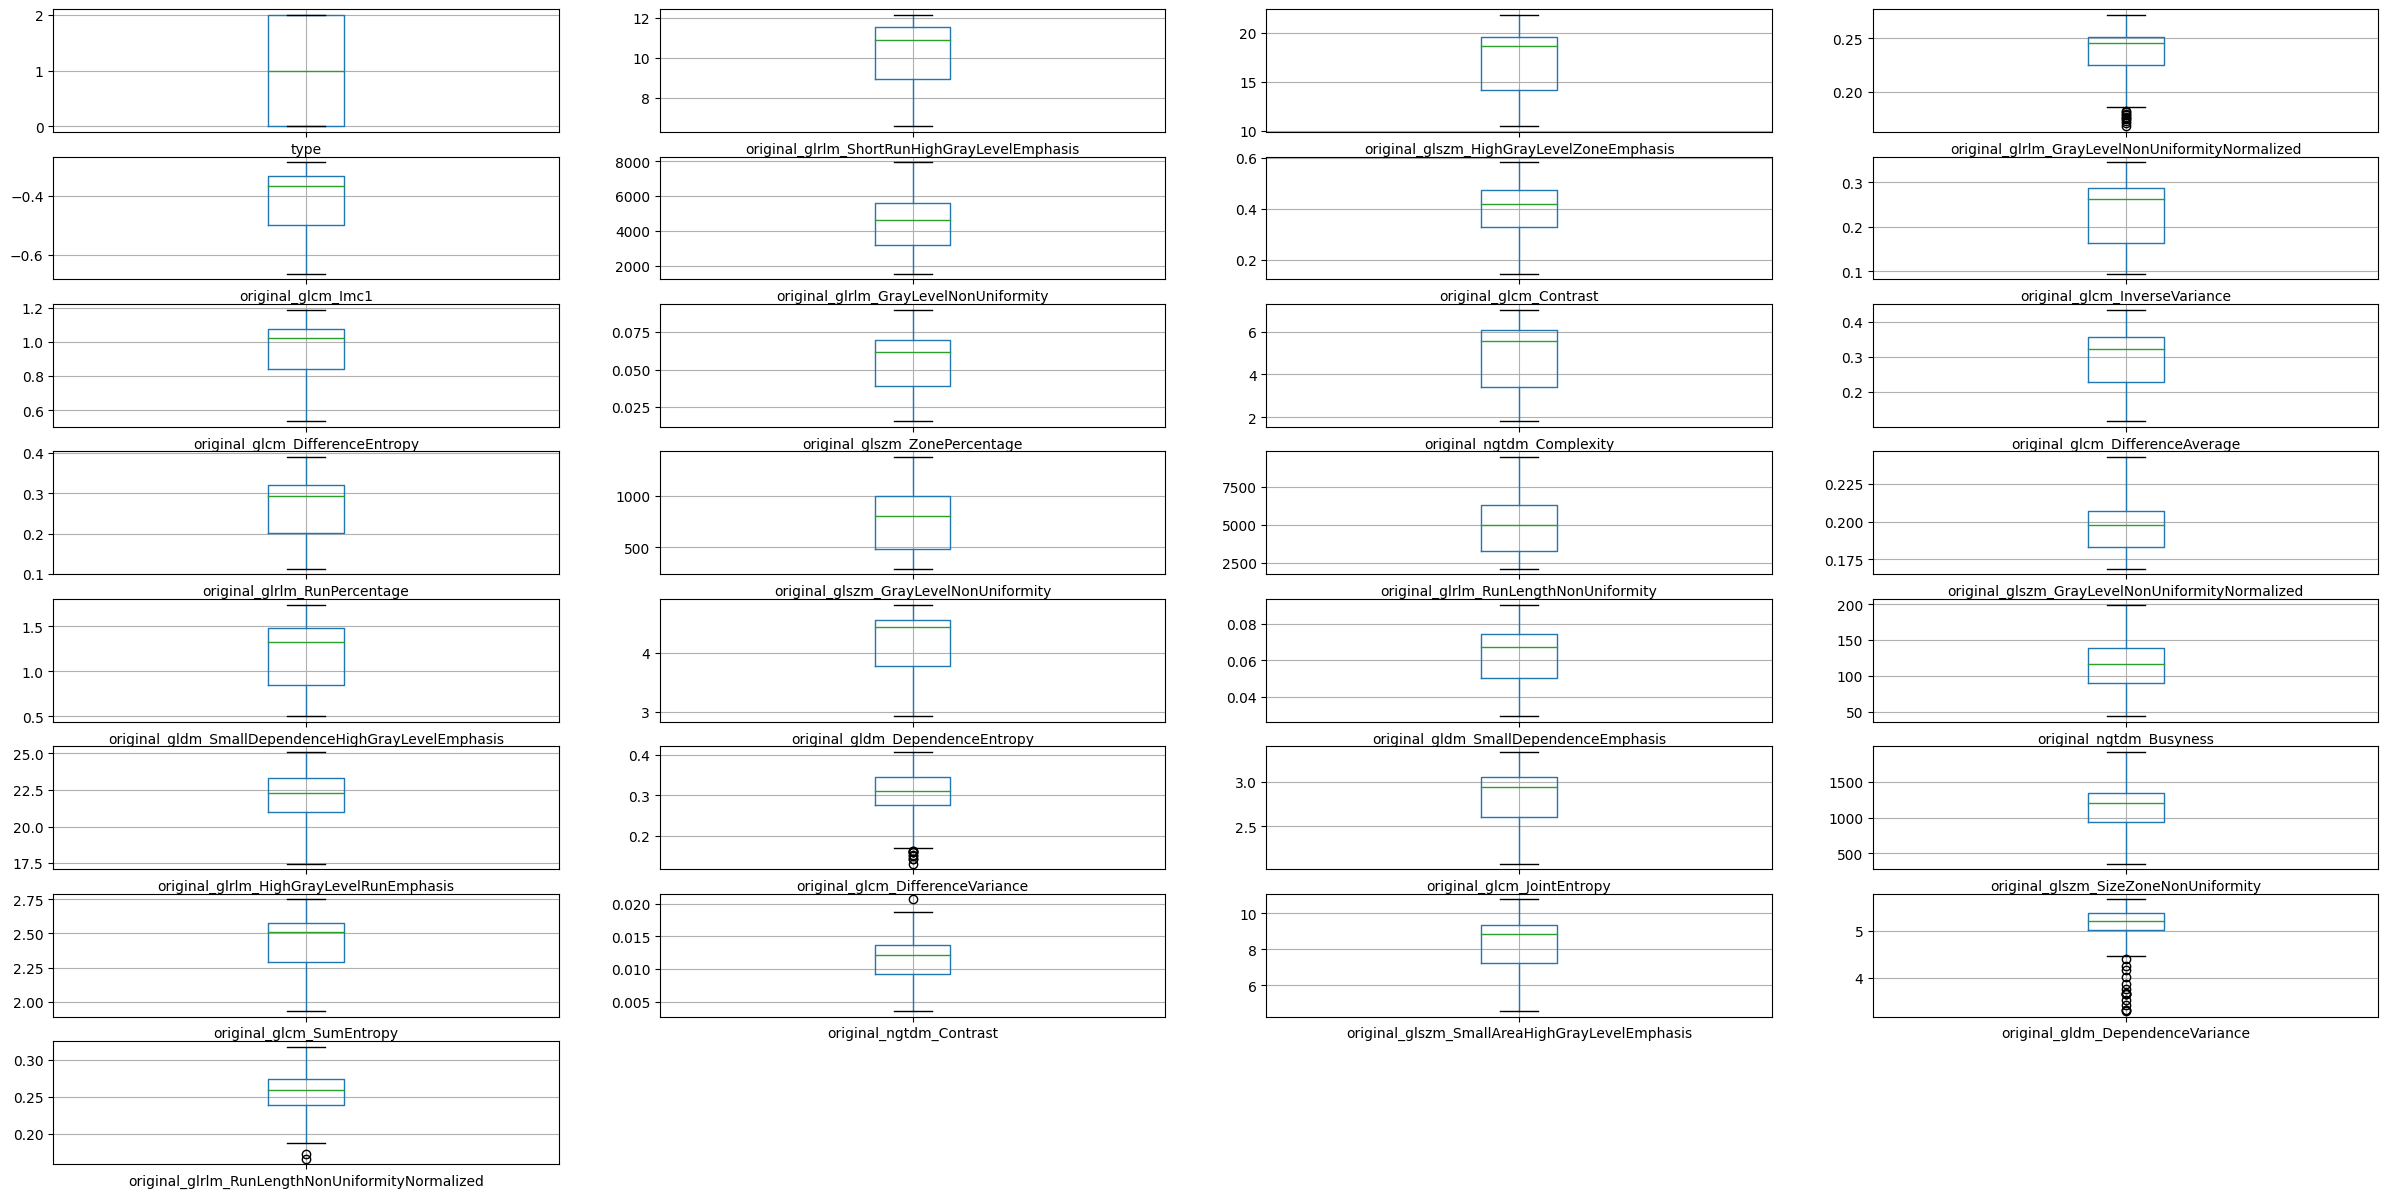

In [ ]:
# Dataset with outliers
a = 1
plt.figure(figsize=(30,15))

for i in df.columns:
    plt.subplot(8,4,a), df.boxplot(i)
    a += 1
plt.show()

In [ ]:
# Function to remove outliers
def eliminar_outliers(dataframe):
    indexes = list()
    for i in dataframe.columns:
        q1 = dataframe[i].quantile(0.25)
        q3 = dataframe[i].quantile(0.75)
        irq = q3 - q1
        pci = q1 - 1.5*irq
        pcs = q3 + 1.5*irq

        index = dataframe.index[(dataframe[i] < pci) | (dataframe[i] > pcs)]
        indexes.extend(index)

    indexes = sorted(set(indexes))
    df_clean = dataframe.drop(indexes)
    return df_clean

In [ ]:
# Normalize with Z-score
def normalizar_df(dataframe):
    ss = StandardScaler()
    ndf = ss.fit_transform(dataframe.values)
    ndf = pd.DataFrame(data = ndf, columns = dataframe.columns)
    return ndf

In [ ]:
# Data correlation
def analisis_correlacion(dfmatrix):
    corr = dfmatrix.corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, annot=True)
    plt.show()

In [ ]:
# Normalized but without eliminating outliers (2)
df_norm = normalizar_df(df)

# Normalized and without outliers (3)
df_noutnorm = eliminar_outliers(df)

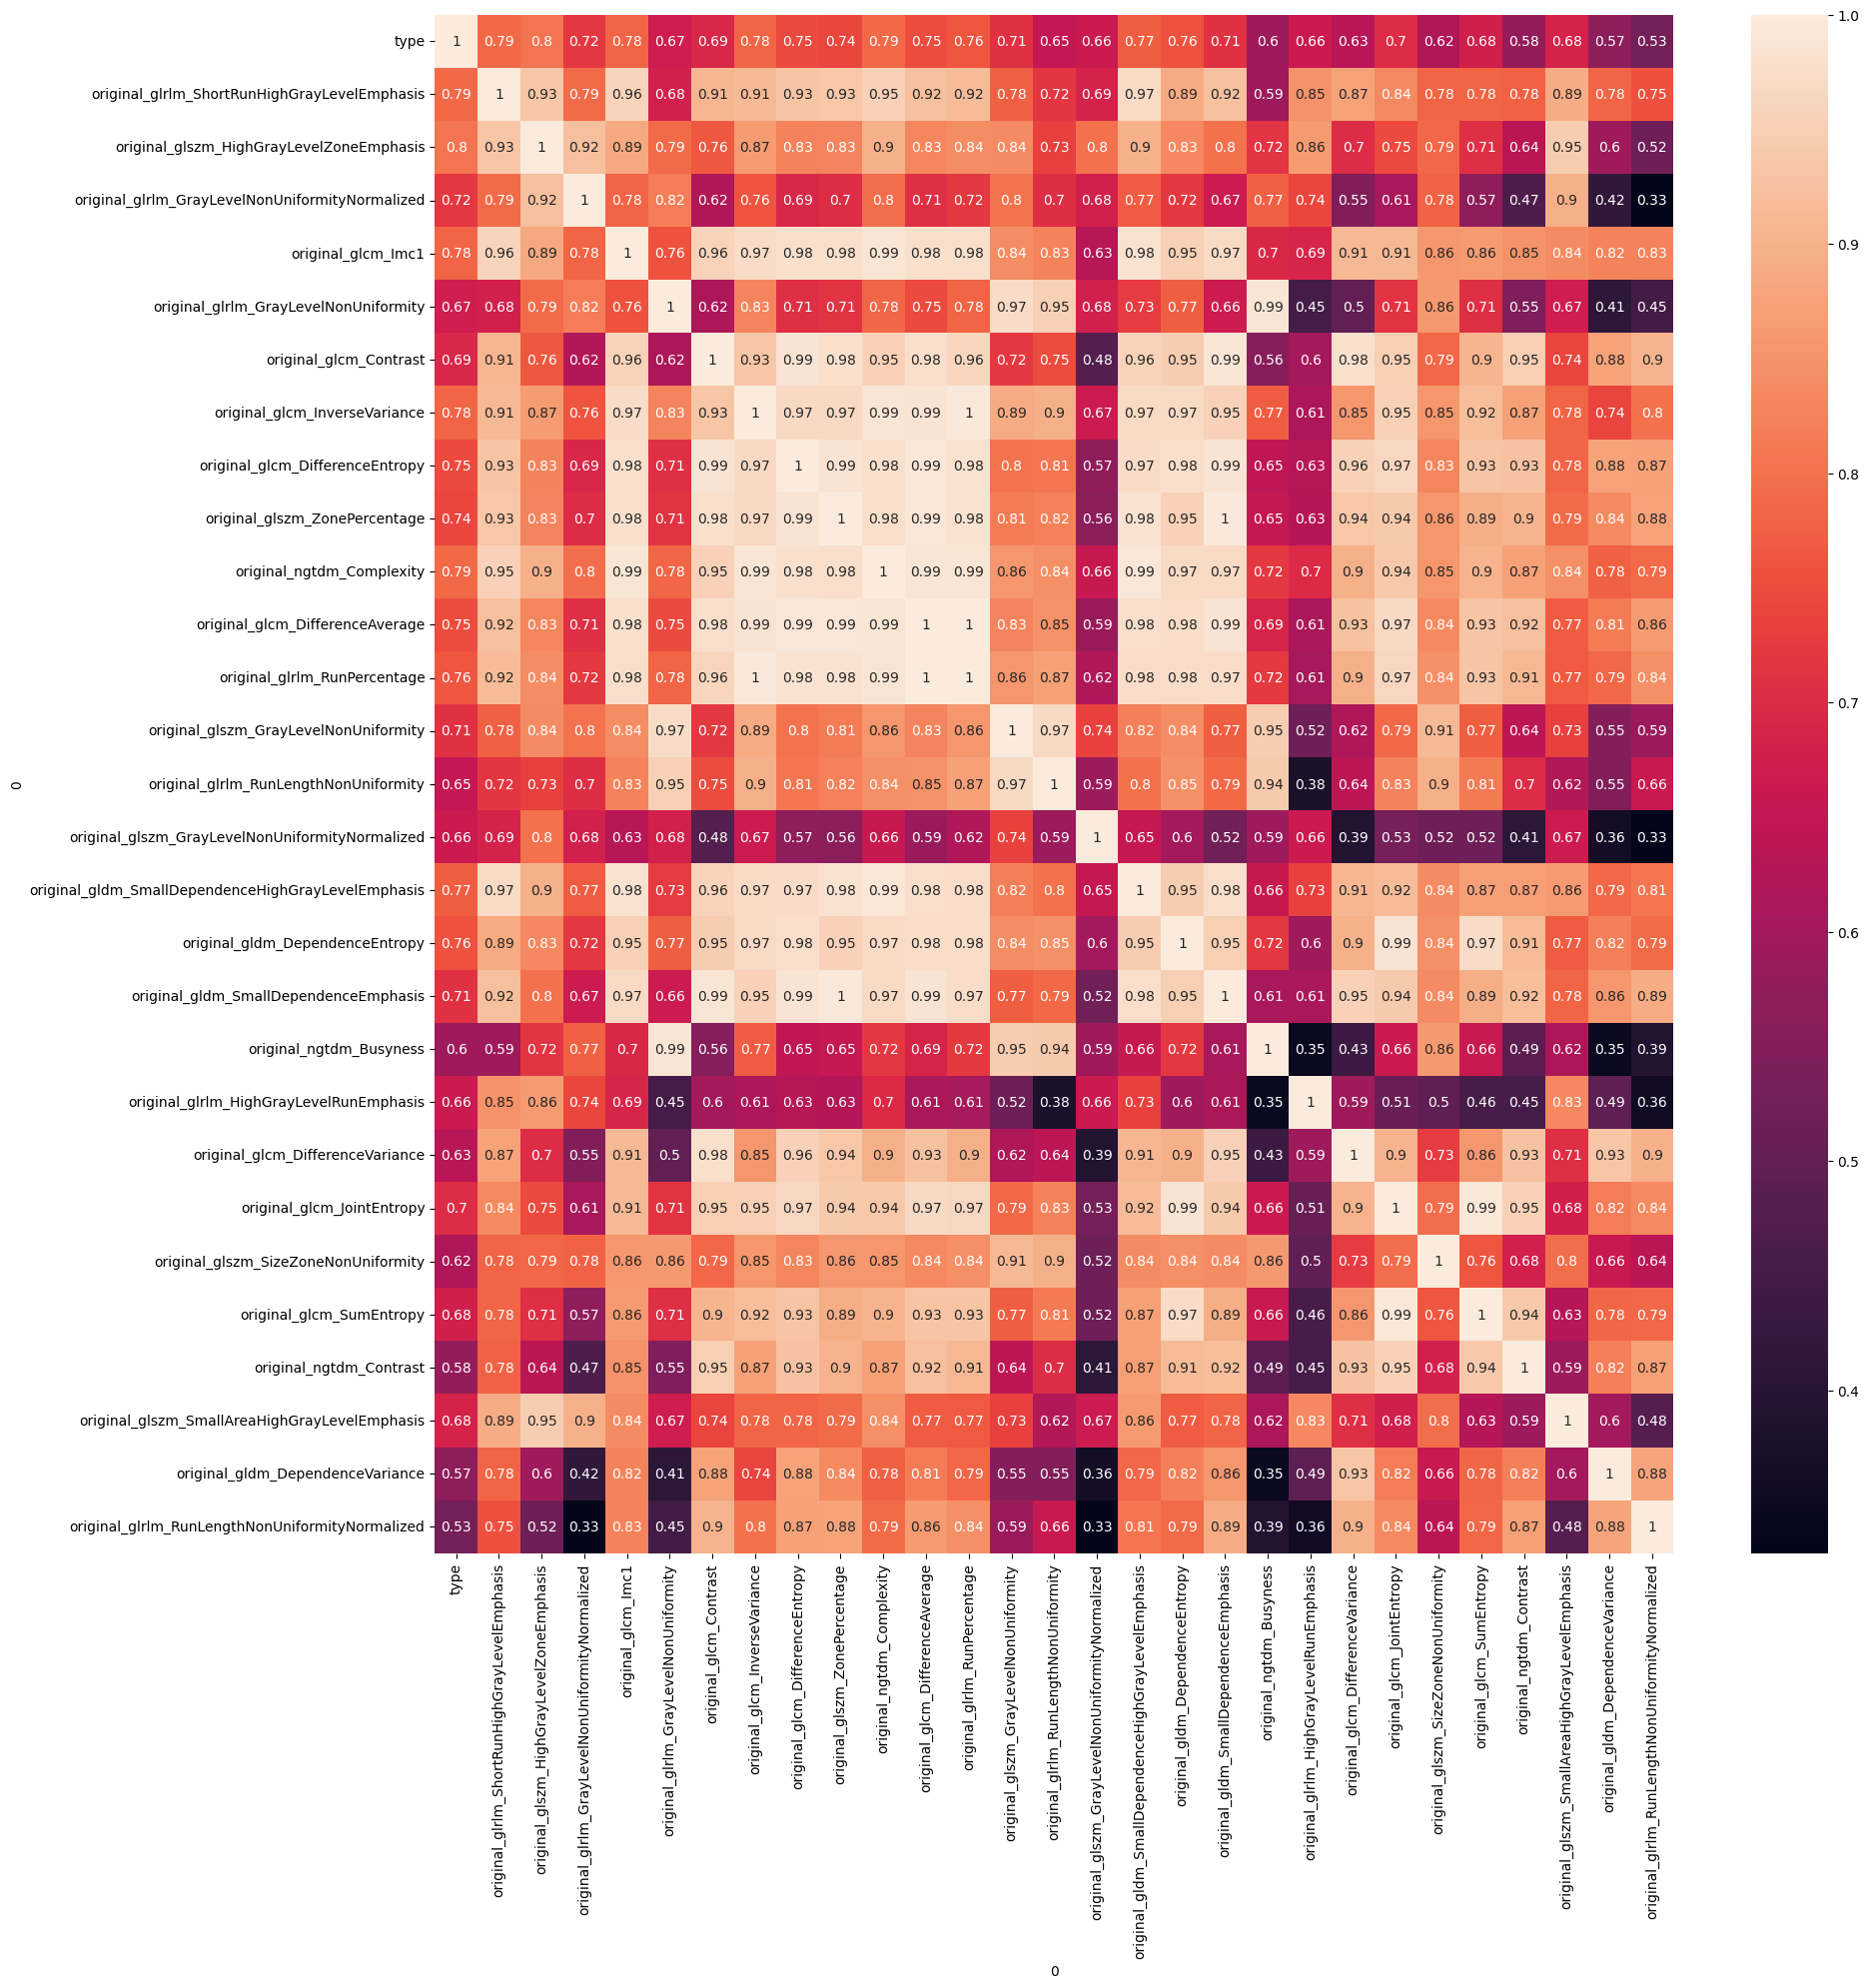

In [ ]:
# Unnormalized with outliers (1)
df.head()
analisis_correlacion(df)

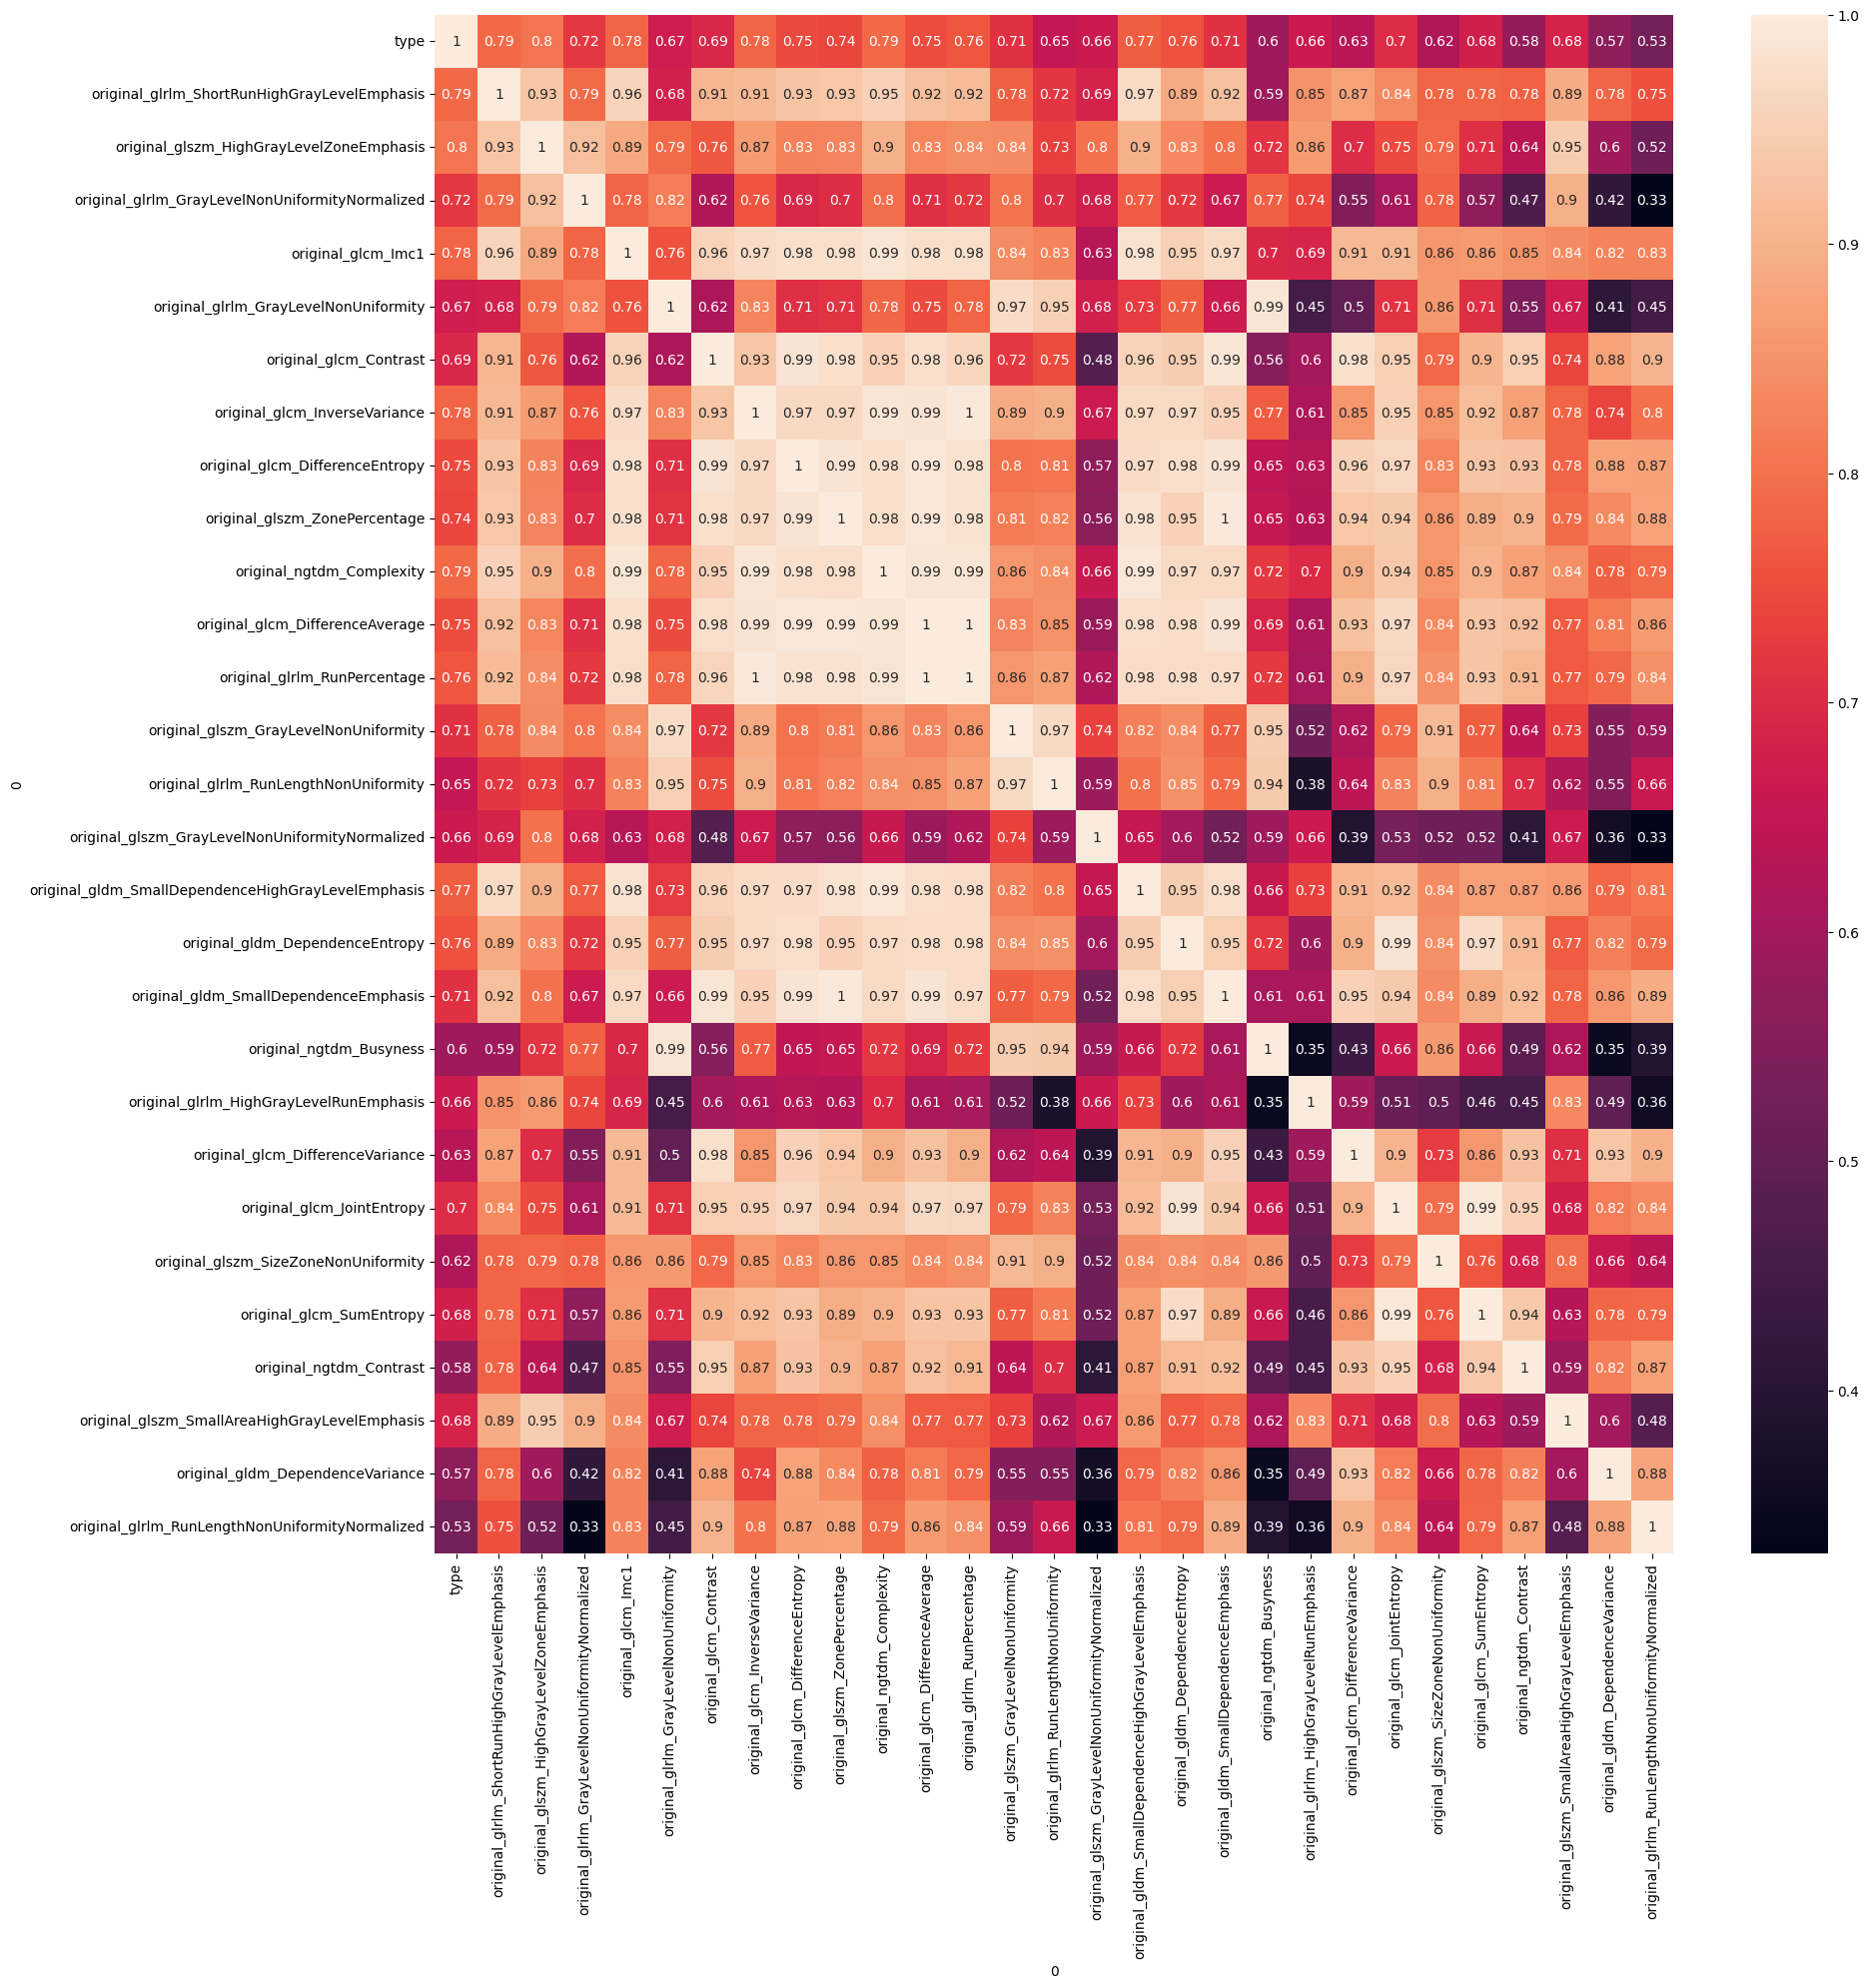

In [ ]:
# Normalized but with outliers (2)
df_norm.head()
analisis_correlacion(df_norm)

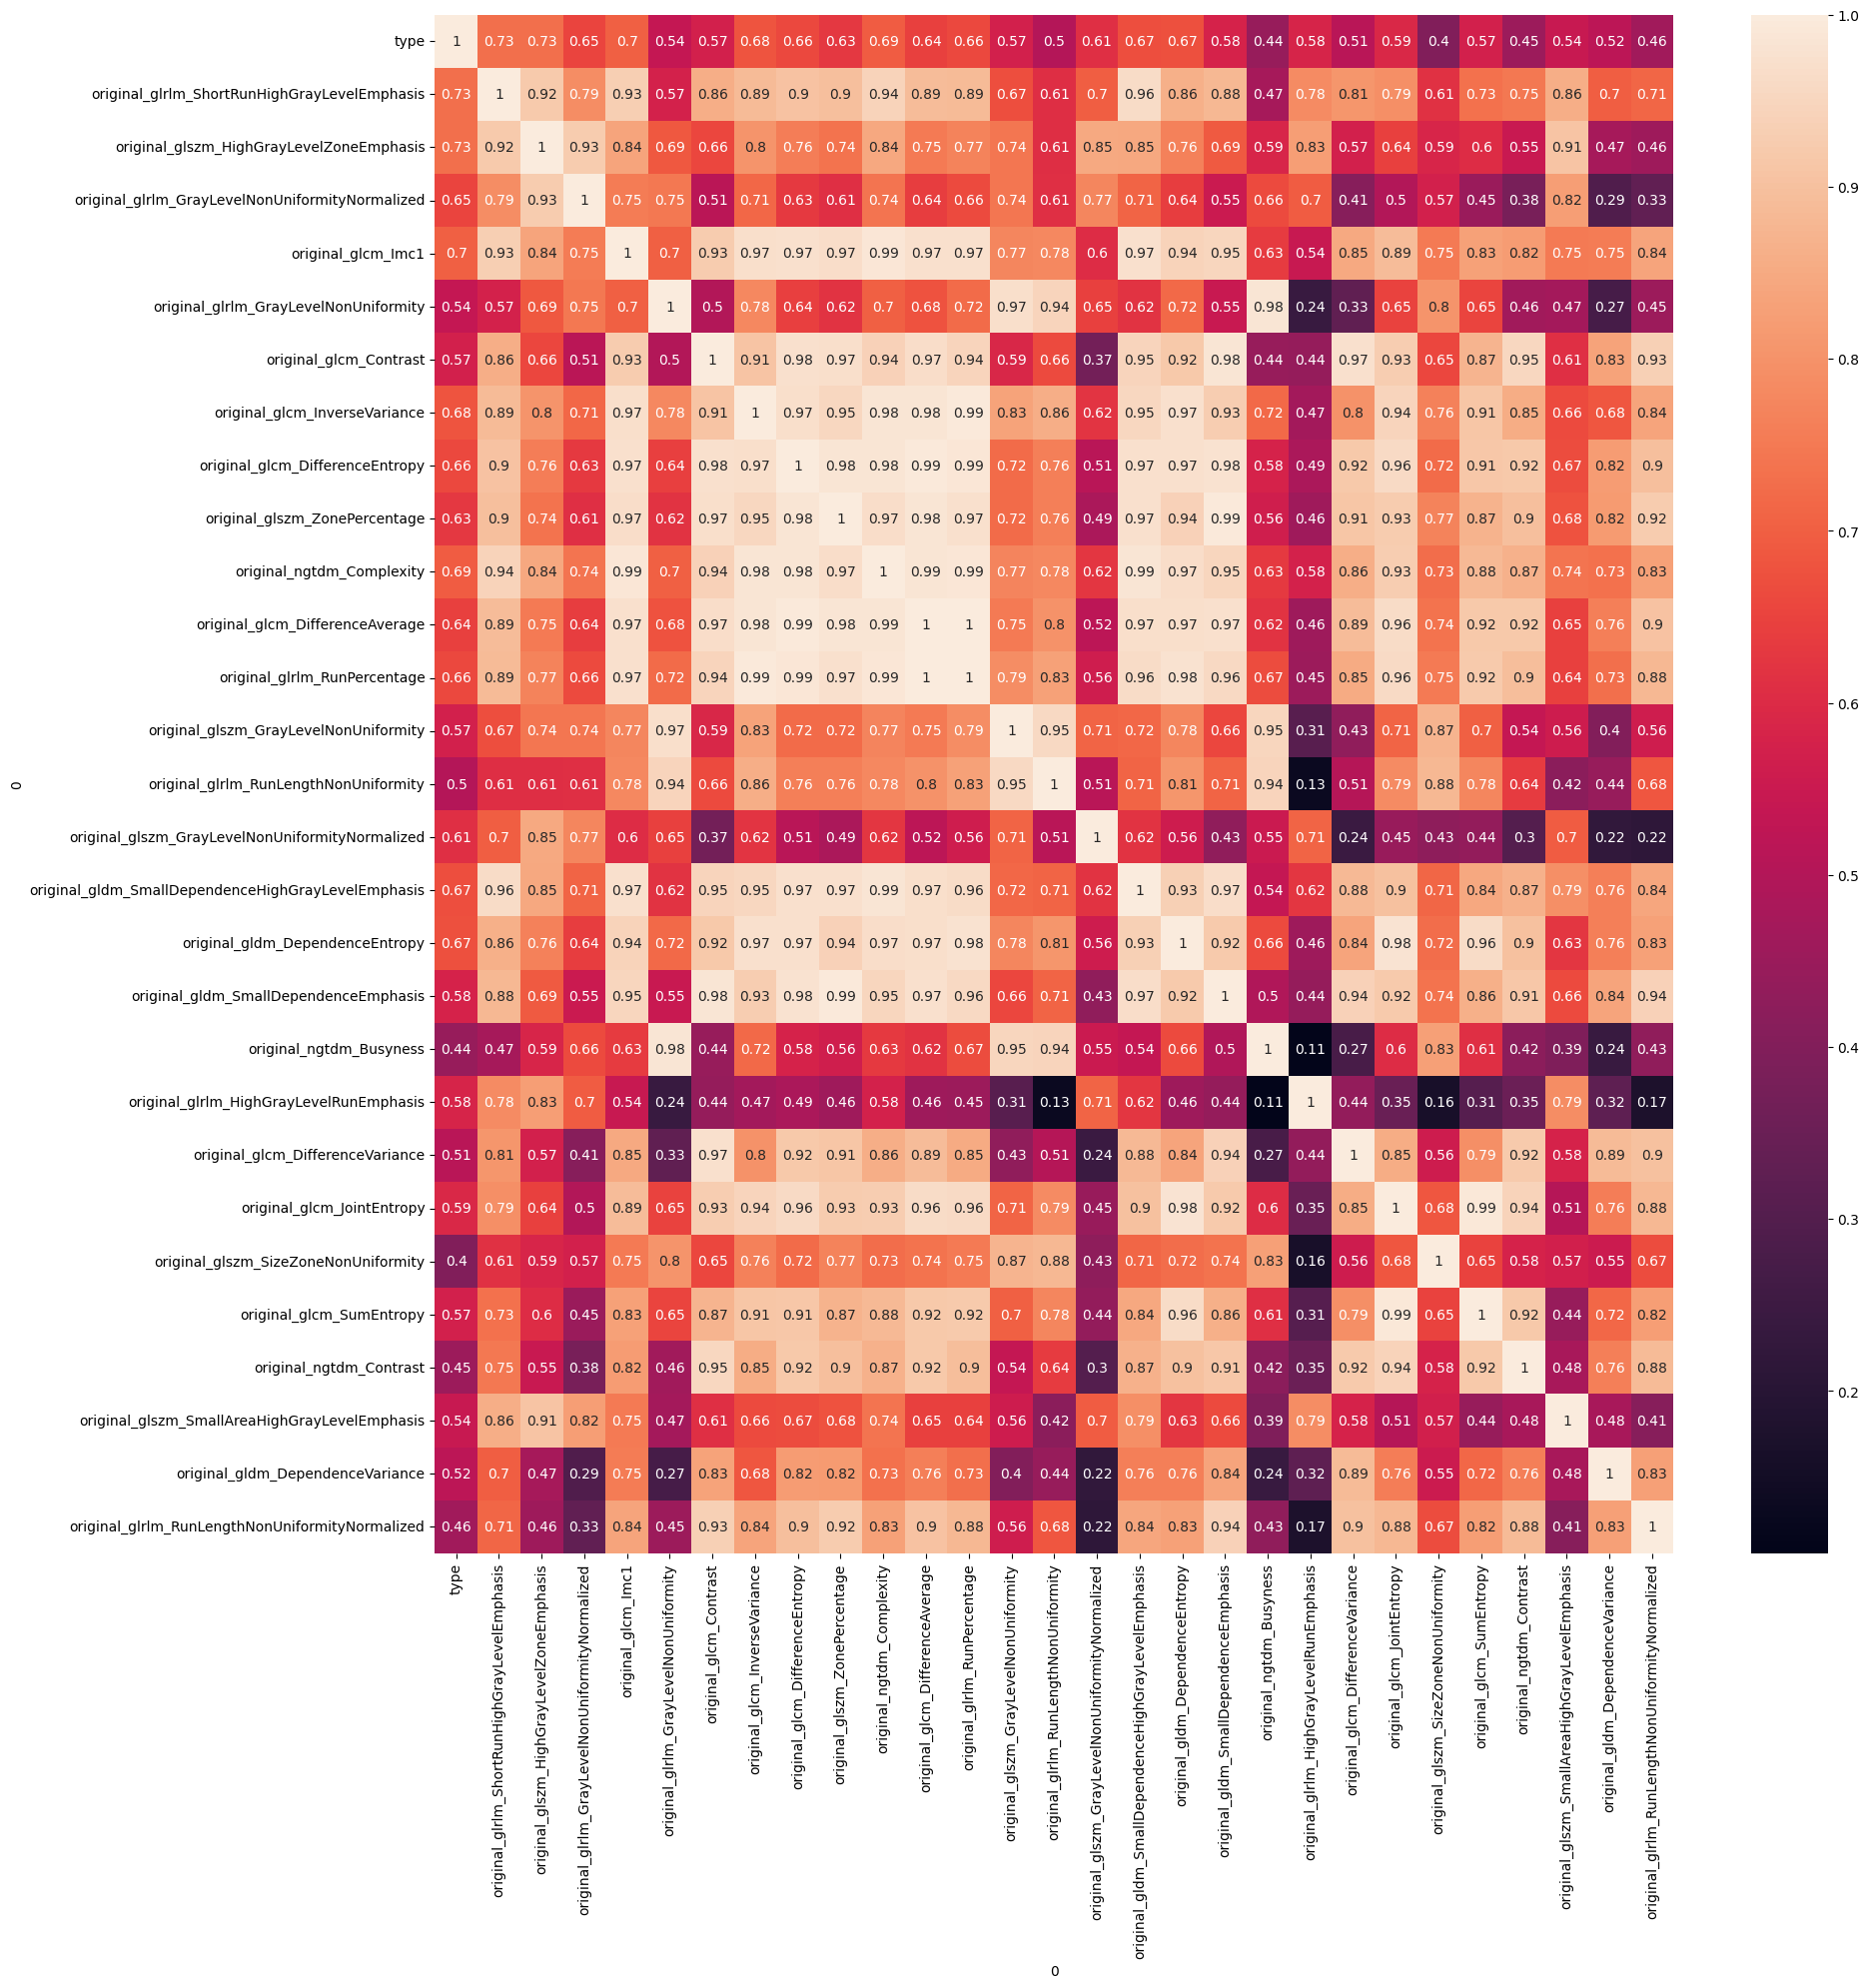

In [ ]:
# Normalized and without outliers (3)
df_noutnorm.head()
analisis_correlacion(df_noutnorm)

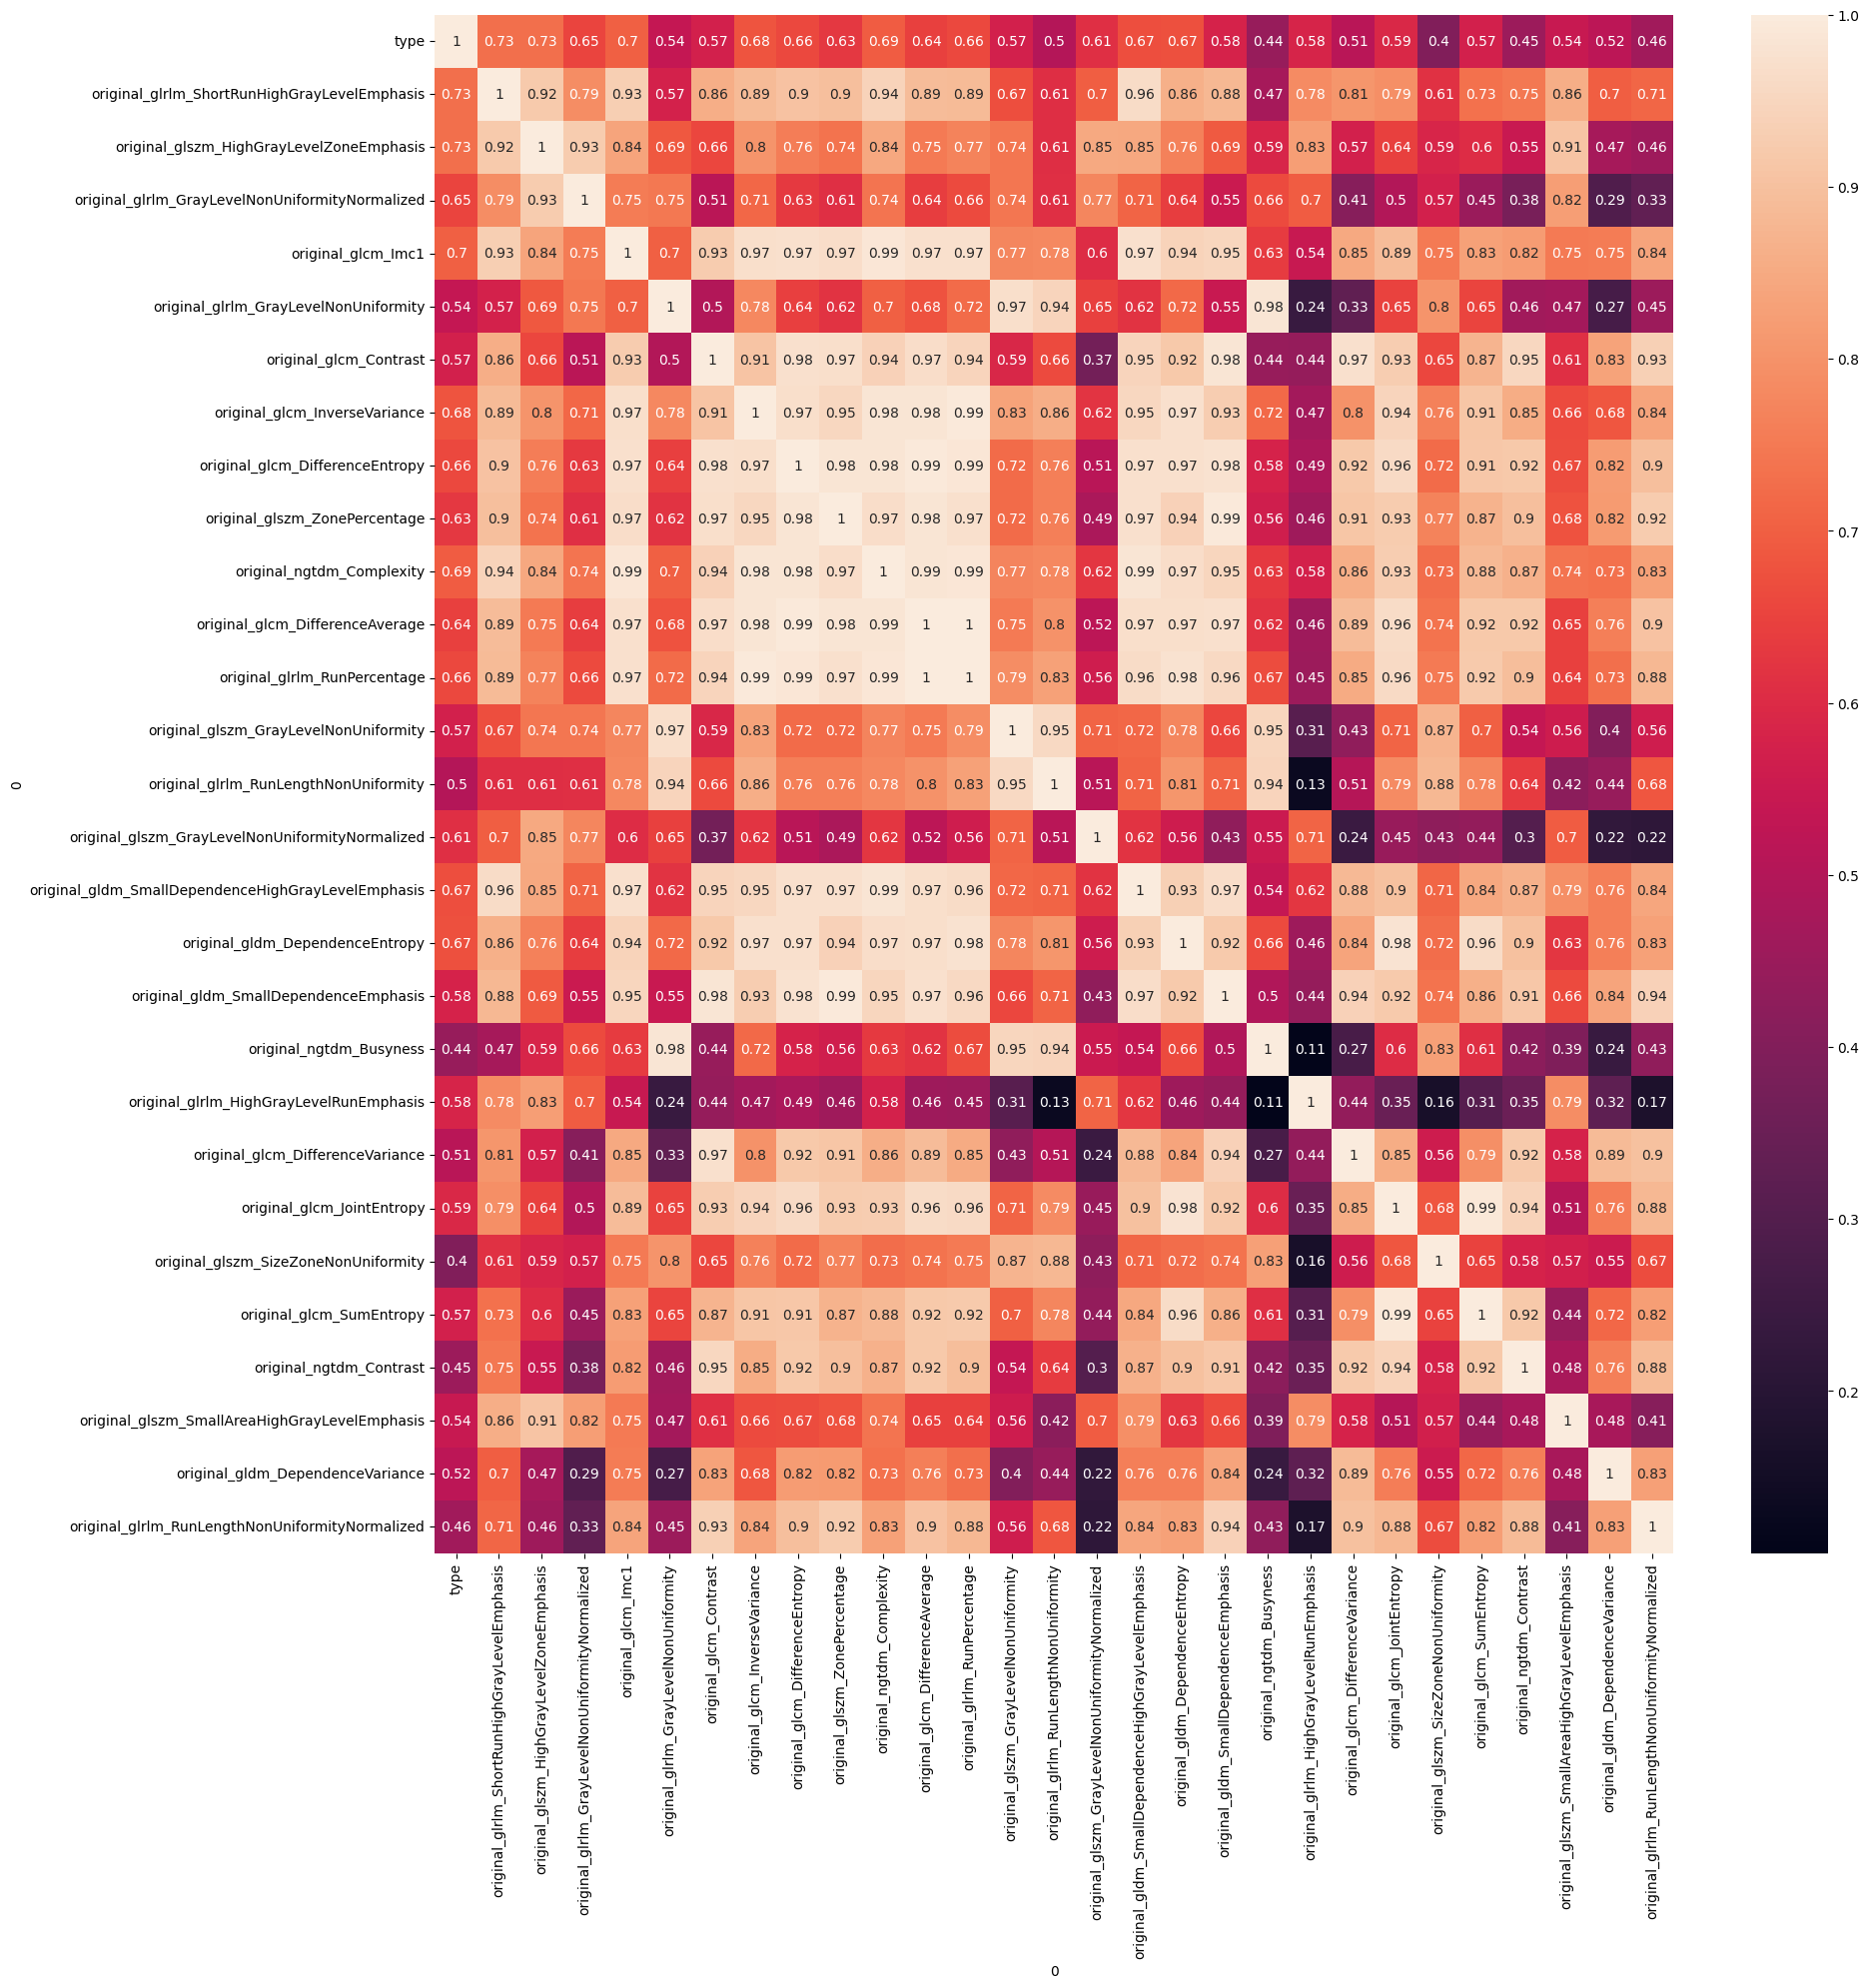

In [ ]:
# Unnormalized but without outliers (4)
df_nout = eliminar_outliers(df)
df_nout.head()
analisis_correlacion(df_nout)

### Probability distribution

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an 

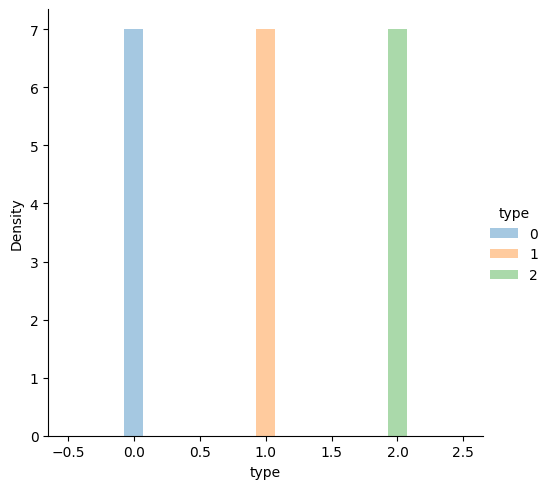

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

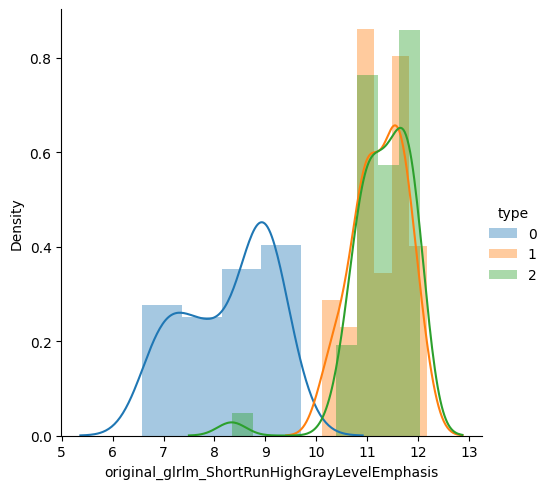

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

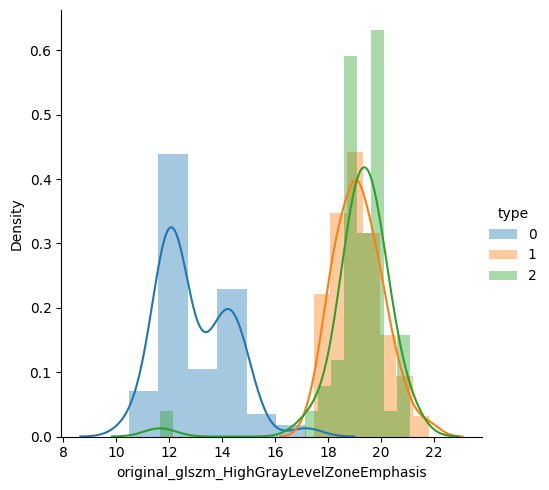

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

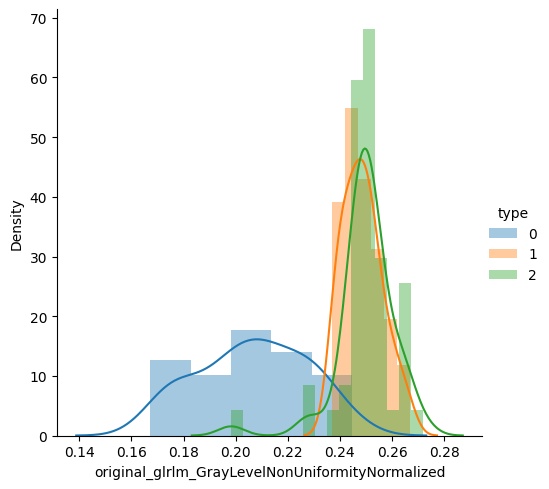

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

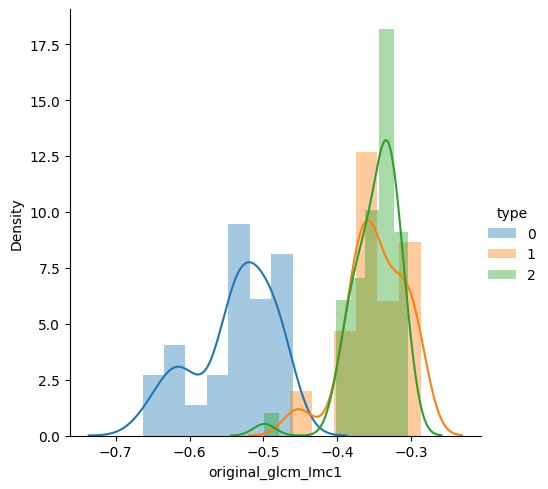

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

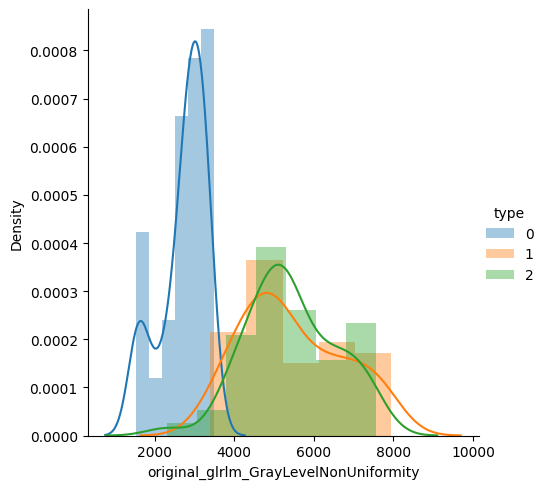

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

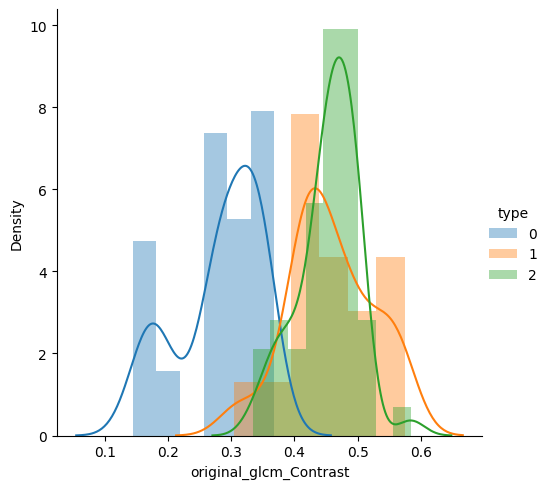

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

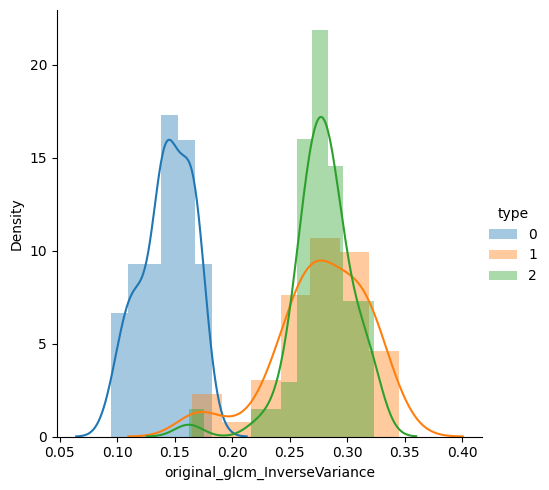

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

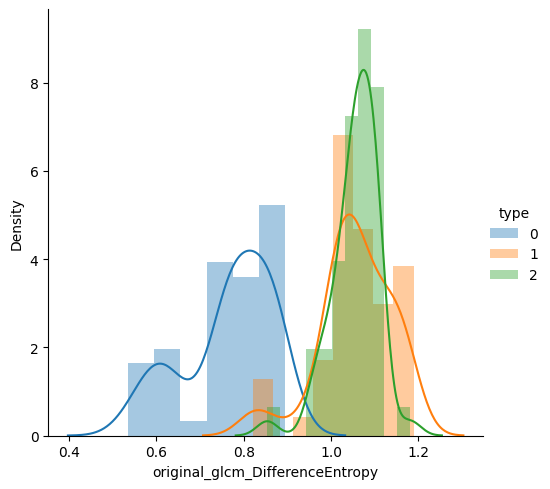

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

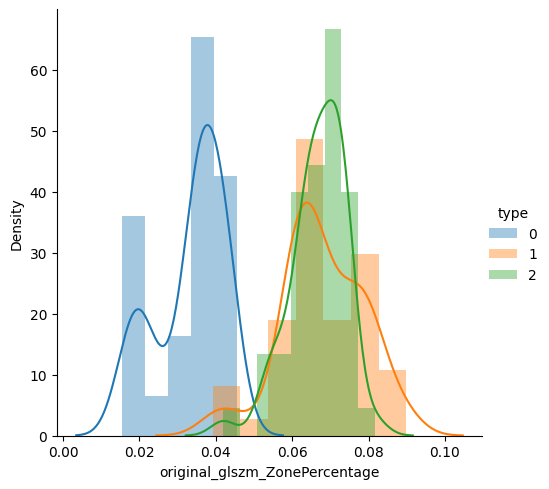

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

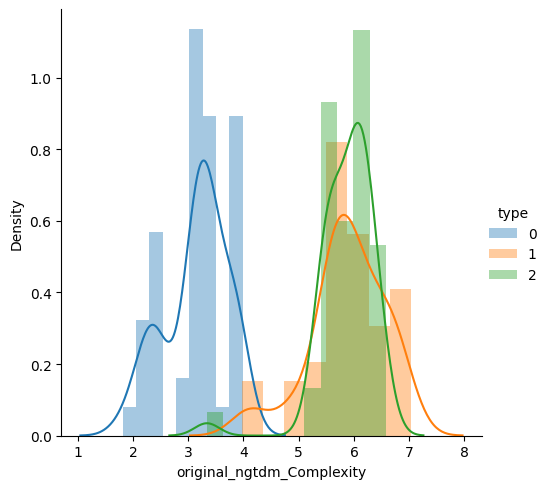

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

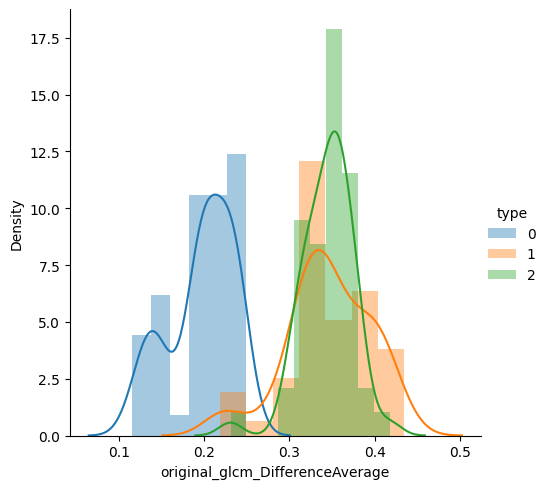

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

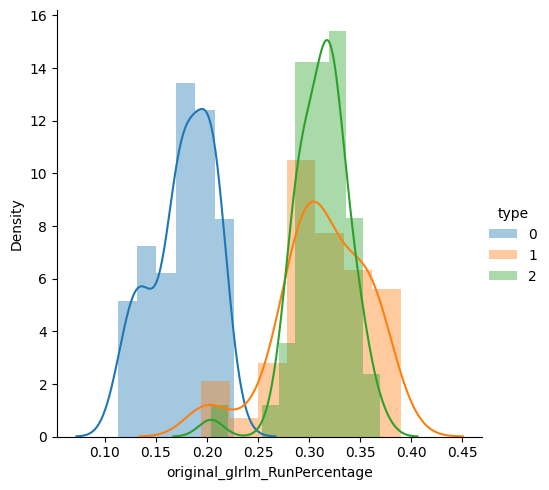

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

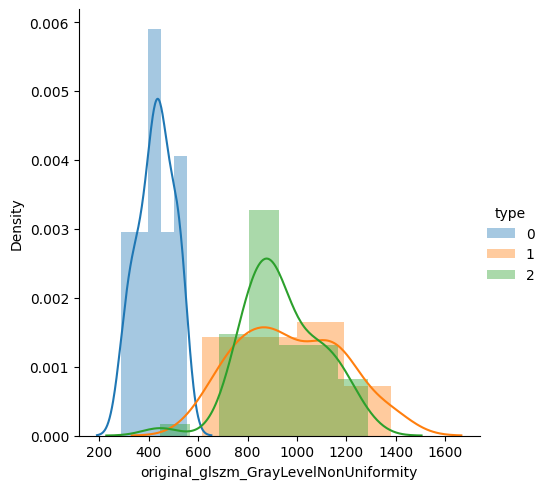

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

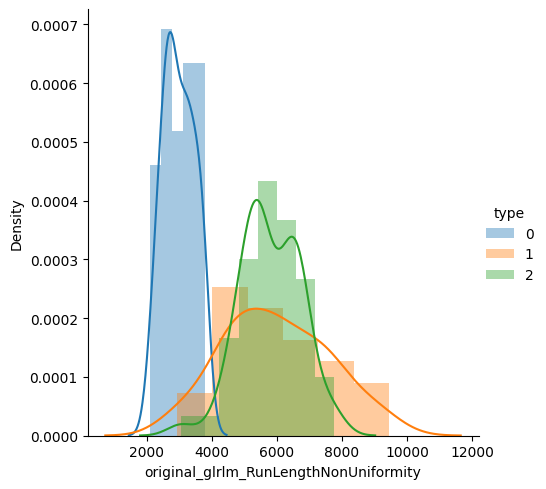

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

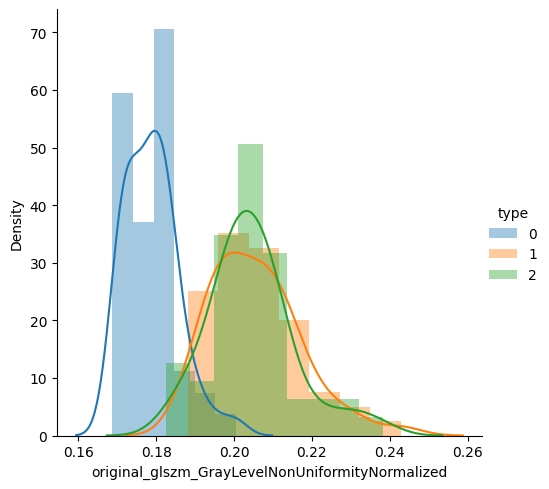

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

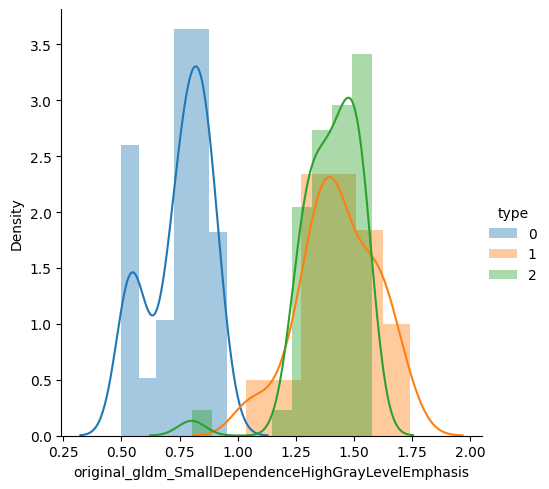

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

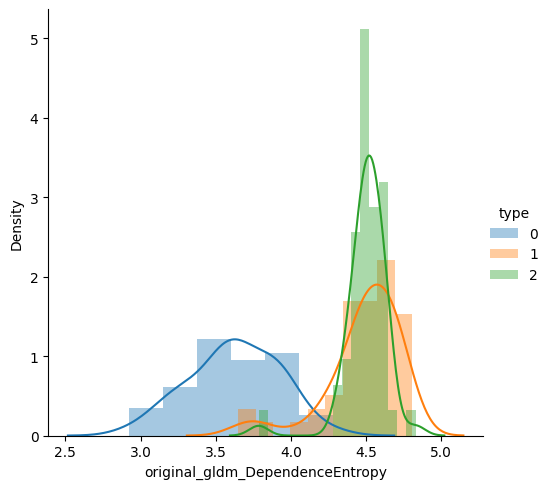

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

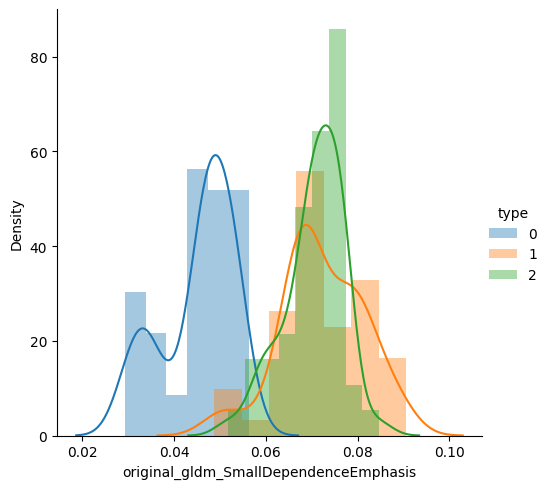

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

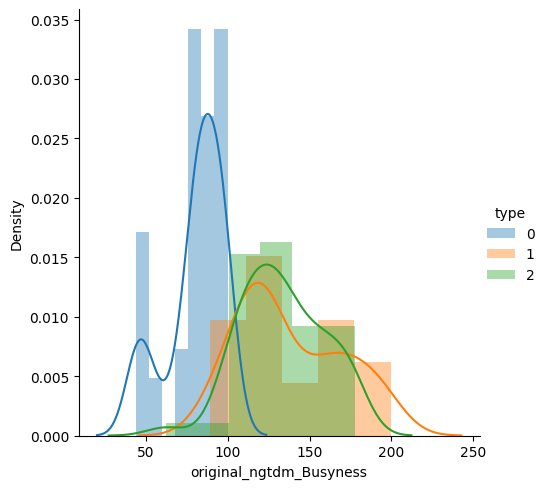

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

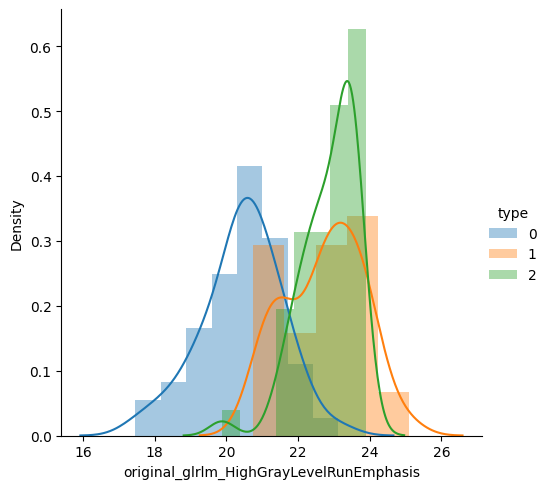

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

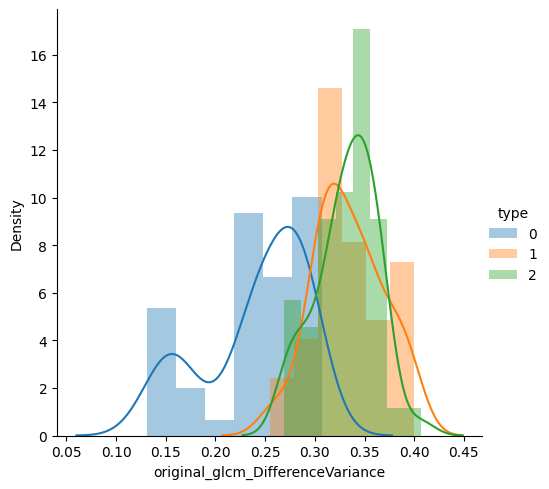

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

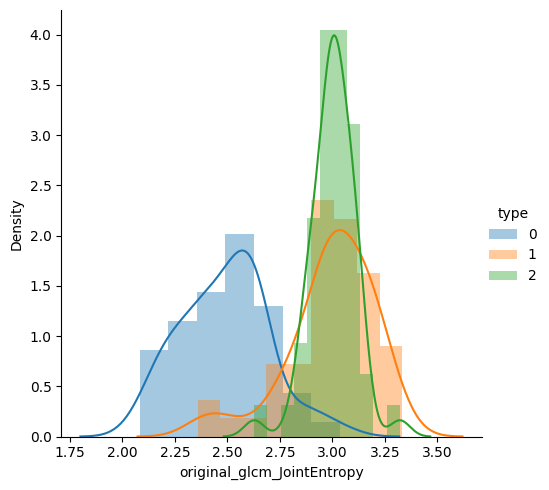

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

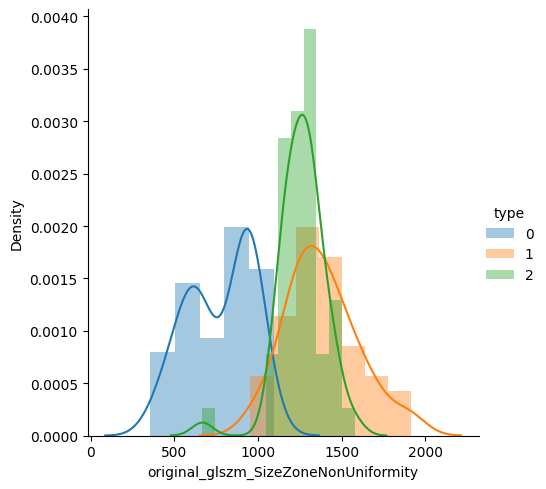

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

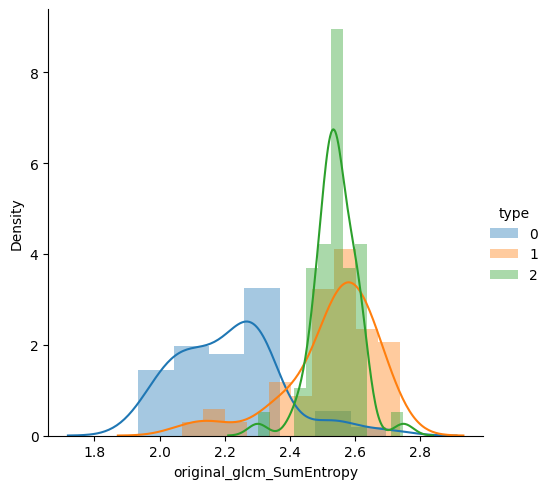

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

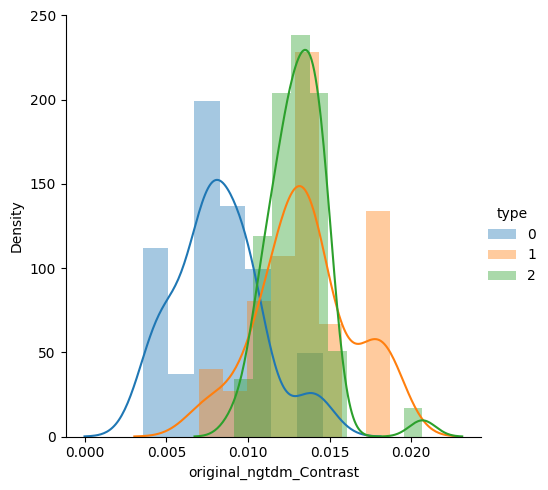

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

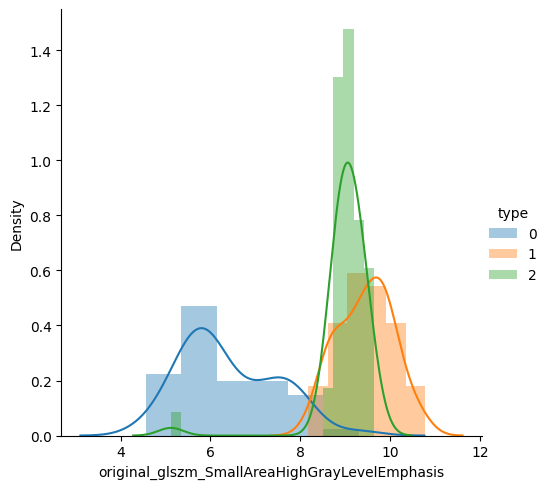

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

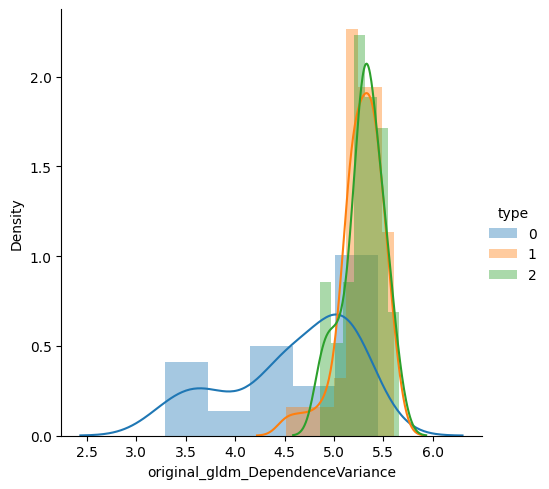

In [ ]:
for i, feature in enumerate(list(df.columns)[:-1]):
    fg = sns.FacetGrid(df, hue='type', height=5)
    fg.map(sns.distplot, feature).add_legend()
    plt.show()

### Model training

In [ ]:
x = df_norm.drop(["type"],axis=1)
y = df[['type']]

In [ ]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Checking the shapes of data sets
print(x.shape)
print(y.shape)
print("--------------")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(153, 28)
(153, 1)
--------------
(107, 28)
(46, 28)
(107, 1)
(46, 1)


We verify the model metrics to ensure its good performance, using a KNN Model to check the algorithm performed

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8913043478260869
Precision: 0.8920619235836627
Recall: 0.8913043478260869
F1-score: 0.8894495060162227


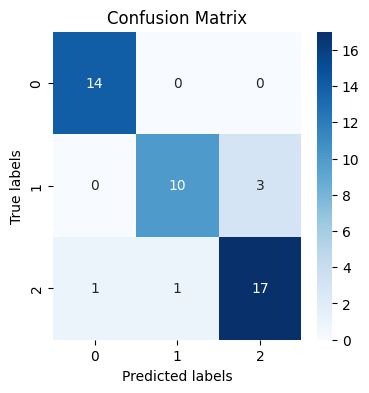

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)

predict = model.predict(x_test)
accuracy=model.score(x_train,y_train)

y_pred = model.predict(x_test)

# Metrics from the model

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(4, 4))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Model performance with different k

In [ ]:
training_accuracy_knn = []
test_accuracy_knn = []
n_neighbors = range(1, 12)

for n in n_neighbors:
    # Build the model
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_train, y_train)
    # Record training set accuracy
    training_accuracy_knn.append(clf.score(x_train, y_train))
    # Record generalization accuracy
    test_accuracy_knn.append(clf.score(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

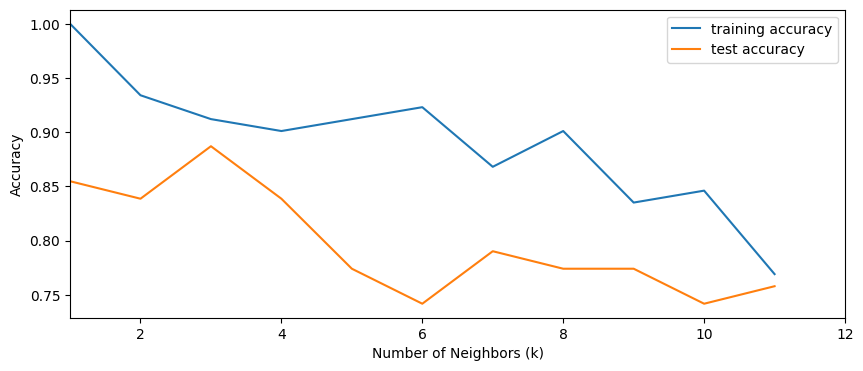

In [ ]:
fig, axe = plt.subplots(ncols=1, figsize=(10, 4))

plt.plot(n_neighbors, training_accuracy_knn, label="training accuracy")
plt.plot(n_neighbors, test_accuracy_knn, label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.xlim(1, 12)

plt.legend()
plt.show()